## Run all the below cells to apply the required models/methods/analysis whatever you are trying to perform.

Note: Save this file in the same folder where you have your 'TRAIN.csv' stored and open it there.

## CAPSTONE PROJECT

### SUPPLEMENENT SALES PREDICTION

### Problem Statement
Supplement Sales Prediction of Client WOMart is a leading nutrition and supplement retail chain that offers a comprehensive range of products for wellness and fitness needs.

Effective forecasting for store sales gives essential insight into upcoming cash flow, meaning WOMart can more accurately plan the cashflow at the store level.

task is to predict the store sales for each store in the test set for the next two months.

## data dictionary
ID: Unique Identifier for a row

Store_id: Unique id for each Store

Store_Type: Type of the Store

Location_Type: Type of the location where Store is located

Region_Code: Code of the Region where Store is located

Date: Information about the Date

Holiday: If there is holiday on the given Date, 1 : Yes, 0 : No

Discount: If discount is offered by store on the given Date, Yes/ No

Orders: Number of Orders received by the Store on the given Day

Sales: Total Sale for the Store on the given Day

## Import Libraries

In [1]:
# import 'Numpy' 
import numpy as np

# import 'Pandas' 
import pandas as pd

# import 'Seaborn'
import seaborn as sns

# import subpackage of Matplotlib
import matplotlib.pyplot as plt

# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

# display formating
pd.options.display.float_format = '{:.6f}'.format
pd.options.display.max_columns = None

import plotly.express as pe
import scipy.stats as stats

# import train-test split
from sklearn.model_selection import train_test_split

# import various functions from statsmodels
import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import GridSearchCV

##  Data preparation

### Understand the Data¶

#### Read the dataset and print the first five observations.

In [2]:
# load the csv file
# store the train data in 'df'
df = pd.read_csv('TRAIN.csv')


# display first five observations using head()

df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.840000
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.120000
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.200000
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.160000
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.520000


In [3]:
# creating a copy of original dataframe (as df1) so that we perform all required steps on df.

df_original = pd.read_csv("TRAIN.csv")
            


In [4]:
# shape of the train data
print('Shape of the train data ',df.shape,'\n')

# using 'info()' to understand the dataset
print(df.info())

Shape of the train data  (188340, 10) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB
None


**Interpretation**: The variable Store_id, Holiday, Order, Sales is numerical. All the other variables are categorical.

From the above output, we see that the data type of Store_id, Holiday is 'int64' and date is 'object'.

But according to the data definition, Store_id, Holiday is categorical variable, which is wrongly interpreted as 'int64', so we will convert these variables data type to 'object', date should be converted to 'date format'.

In [5]:
# converting holiday and store_id to categorical variable
# use astype() to change the data type

df['Holiday']=df['Holiday'].astype('object')
df['Store_id']=df['Store_id'].astype('object')

# converting date to date format
df['Date']=pd.to_datetime(df['Date'])

# renaming #order column to order
df.columns=df.columns.str.replace('#','')

In [6]:
# checking data types after converting
df.dtypes

ID                       object
Store_id                 object
Store_Type               object
Location_Type            object
Region_Code              object
Date             datetime64[ns]
Holiday                  object
Discount                 object
Order                     int64
Sales                   float64
dtype: object

In [7]:
# summary report of the numerical data type
df.describe()

,Order,Sales
count,188340.000000,188340.000000
mean,68.205692,42784.327982
std,30.467415,18456.708302
min,0.000000,0.000000
25%,48.000000,30426.000000
50%,63.000000,39678.000000
75%,82.000000,51909.000000
max,371.000000,247215.000000


**Interpration** As the orders are increasing sales is also increasing, we clearly understand in the data we are having some outliers by refering the 75% and the max of the variables

In [8]:
# summary report for the categorical veriable
df.describe(include='object')

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount
count,188340,188340,188340,188340,188340,188340,188340
unique,188340,365,4,5,4,2,2
top,T1000001,1,S1,L1,R1,0,No
freq,1,516,88752,85140,63984,163520,104051


### Outeliers

<AxesSubplot:>

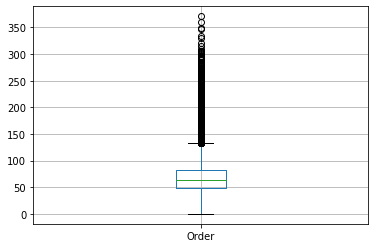

In [9]:
df.boxplot('Order')

<AxesSubplot:>

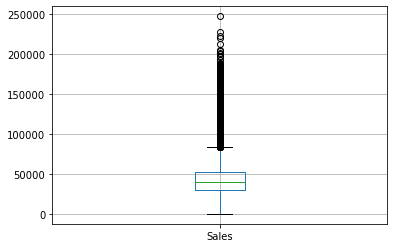

In [10]:
df.boxplot('Sales')

### Check for duplicate values

In [11]:
df.duplicated().sum()

0


In order to have a better outlier treatment, we will check for any duplicates based on Store_id and Date. As there can be a possibility of duplicates exisitng in these features

In [12]:
df[['Store_id','Date']].duplicated().sum()

0

**Intrepatation** we have no duplicate values in the data

### Working with 'Date' column

Creating new features like day, month, year and day of week using variable date for better analysis

In [13]:
df['Year']=pd.DatetimeIndex(df['Date']).year
df['Month']=pd.DatetimeIndex(df['Date']).month
df['Day']=pd.DatetimeIndex(df['Date']).day
df['day of week']=pd.DatetimeIndex(df['Date']).strftime("%A")
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,Year,Month,Day,day of week
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.840000,2018,1,1,Monday
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.120000,2018,1,1,Monday
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.200000,2018,1,1,Monday
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.160000,2018,1,1,Monday
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.520000,2018,1,1,Monday


In [14]:
# converting data types for day, month, year
df['Year']=df['Year'].astype('object')
df['Month']=df['Month'].astype('object')
df['Day']=df['Day'].astype('object')
df.dtypes

ID                       object
Store_id                 object
Store_Type               object
Location_Type            object
Region_Code              object
Date             datetime64[ns]
Holiday                  object
Discount                 object
Order                     int64
Sales                   float64
Year                     object
Month                    object
Day                      object
day of week              object
dtype: object

### Missing Value Analysis and Treatment¶
####   Check the presence of missing values in the data and treat them.

In [15]:
# sort the variables on the basis of total null values in the variable
# 'isnull().sum()' returns the number of missing values in each variable
# 'ascending = False' sorts values in the descending order
# the variable with highest number of missing values will appear first
Total = df.isnull().sum().sort_values(ascending=False)          

# calculate percentage of missing values
# 'ascending = False' sorts values in the descending order
# the variable with highest percentage of missing values will appear first
Percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)   

# concat the 'Total' and 'Percent' columns using 'concat' function
# pass a list of column names in parameter 'keys' 
# 'axis = 1' concats along the columns
missing_data = pd.concat([Total, Percent], axis=1, keys=['Total', 'Percentage of Missing Values'])    
missing_data

,Total,Percentage of Missing Values
ID,0,0.000000
Store_id,0,0.000000
Store_Type,0,0.000000
Location_Type,0,0.000000
Region_Code,0,0.000000
Date,0,0.000000
Holiday,0,0.000000
Discount,0,0.000000
Order,0,0.000000
Sales,0,0.000000


**Interpretation :** there are no missing values in the train data

### Dropping insignificant variables

In [16]:
df.drop('ID',axis=1,inplace= True)
df.head()

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,Year,Month,Day,day of week
0,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.840000,2018,1,1,Monday
1,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.120000,2018,1,1,Monday
2,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.200000,2018,1,1,Monday
3,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.160000,2018,1,1,Monday
4,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.520000,2018,1,1,Monday


**Interpretation:** since variable ID will not be used for our analysis we are dropping it

## Exploratory Data Analysis

### UNIVARIATE ANALYSIS

### Categorical varibles: distribution of values

Store_Type
S1            88752
S4            45924
S2            28896
S3            24768
dtype: int64


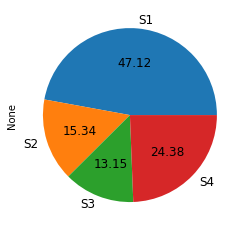


Location_Type
L1               85140
L2               48504
L3               29928
L5               13932
L4               10836
dtype: int64


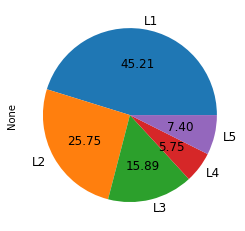


Region_Code
R1             63984
R2             54180
R3             44376
R4             25800
dtype: int64


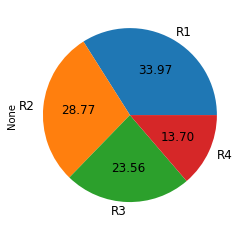


Holiday
0          163520
1           24820
dtype: int64


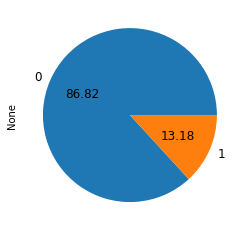


Discount
No          104051
Yes          84289
dtype: int64


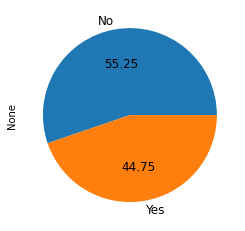

In [17]:
dfc = df[['Store_Type', 'Location_Type', 'Region_Code','Holiday', 'Discount']]
for i in dfc.columns:
    print(dfc[[i]].value_counts())
    dfc.groupby(i).size().plot(kind='pie', autopct='%.2f',textprops={'fontsize': 12})
    plt.show()
    print()

### Numerical variables: finding Outliers, Skewness, Standard deviation, min and max

Order :

Skewness= 1.3728735099625982
Kurtosis= 3.680360669037022


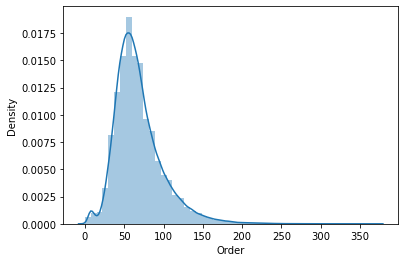

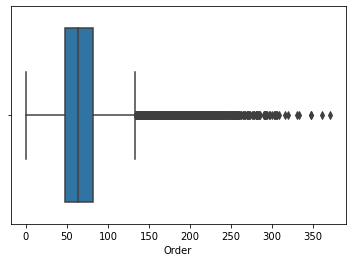


---------------------------------------------------
Sales :

Skewness= 1.248819154338717
Kurtosis= 3.4854444713249486


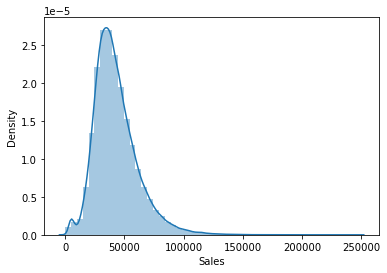

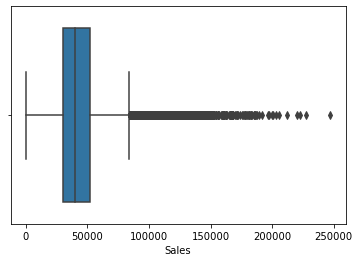


---------------------------------------------------


In [18]:
dfn = df[['Order','Sales']]
skew = dfn.skew()

for i in dfn.columns:
    print(i,':')
    print()
    print('Skewness=', dfn[i].skew())
    print('Kurtosis=', dfn[i].kurt())

    sns.distplot(dfn[i])
    plt.show()

    sns.boxplot(dfn[i])
    plt.show()
    print()
    print('---------------------------------------------------')

As we can see:

'Sales' is right skewed.It is leptokurtic, and has wide tail
IQR of Sales lies from 0-81000
Outliers are present.

As we can see:

'Order' is right skewed.It is leptokurtic, and has wide tail
IQR of Order lies from 0-130
Outliers are present.

### Standard Deviation

In [19]:
dfn.std()

Order      30.467415
Sales   18456.708302
dtype: float64

Both the numerical variables are having high standard deviation hence both are highly important.

### Min and Max values

In [20]:
for i in dfn.columns:
    print(i)
    print('Minimum value=',dfn[i].min())
    print('Maximum value=',dfn[i].max())
    print()

Order
Minimum value= 0
Maximum value= 371

Sales
Minimum value= 0.0
Maximum value= 247215.0



In [21]:
dfn.describe()

,Order,Sales
count,188340.000000,188340.000000
mean,68.205692,42784.327982
std,30.467415,18456.708302
min,0.000000,0.000000
25%,48.000000,30426.000000
50%,63.000000,39678.000000
75%,82.000000,51909.000000
max,371.000000,247215.000000


### Creating bins for Store_id 

In [22]:
dfc.columns

Index(['Store_Type', 'Location_Type', 'Region_Code', 'Holiday', 'Discount'], dtype='object')

In [23]:
df.Store_id.value_counts()

1      516
61     516
63     516
64     516
65     516
      ... 
338    516
349    516
350    516
351    516
364    516
Name: Store_id, Length: 365, dtype: int64

As we can see, Store_id is a categorical variable but has 365 categories (Store_id's) in it. 

As there are 365 Store_id values, we decide to bin this varriable for putting it to use.
We will bin the Store_id variable on the basis of 'Order' variable as this will provide us with better insight.

In [24]:
def func1(a):
    if a <=20000:
        return 'low_sales'
    elif 20000<a<=40000:
        return 'medium_sales'
    elif 40000<a<=60000:
        return 'high_sales'
    else:
        return 'very_high_sales'

In [25]:
df['store_cat']=df['Sales'].apply(func1)
df.head()

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,Year,Month,Day,day of week,store_cat
0,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.840000,2018,1,1,Monday,low_sales
1,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.120000,2018,1,1,Monday,high_sales
2,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.200000,2018,1,1,Monday,medium_sales
3,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.160000,2018,1,1,Monday,low_sales
4,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.520000,2018,1,1,Monday,high_sales


Hence we follow binning of Stores on the basis of sales. 
This helps us understand more about the classes of stores with different categorization of sales.

### BIVARIATE ANALYSIS

1) Store_id's which covers top 20% of sales

In [26]:
df.head()

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,Year,Month,Day,day of week,store_cat
0,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.840000,2018,1,1,Monday,low_sales
1,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.120000,2018,1,1,Monday,high_sales
2,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.200000,2018,1,1,Monday,medium_sales
3,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.160000,2018,1,1,Monday,low_sales
4,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.520000,2018,1,1,Monday,high_sales


In [27]:
np.sum(df.groupby('Store_id')['Sales'].agg('sum').sort_values(ascending=False))

8058000332.04

In [28]:
s1=np.cumsum(df.groupby('Store_id')['Sales'].agg('sum').sort_values(ascending=False))/df.Sales.sum()*100

s20=s1[s1<=20.0]
print(len(s20.index))


46


In [29]:
s20=df.groupby('Store_id')['Sales'].sum().sort_values(ascending=False)[0:46]

In [30]:
s20.index

Int64Index([175, 337, 126, 312, 146, 160, 153, 354, 173,  87, 315,  85, 336,
            176, 131, 294, 219, 150,  11,  15, 115, 286, 139, 212, 147, 303,
            298, 158,  82, 280,   3, 339, 157, 198, 127, 338, 222, 211, 125,
            311, 274,  10, 102, 346,  47,  33],
           dtype='int64', name='Store_id')

This is the list of Store_id's that cover top 20% of the Sales

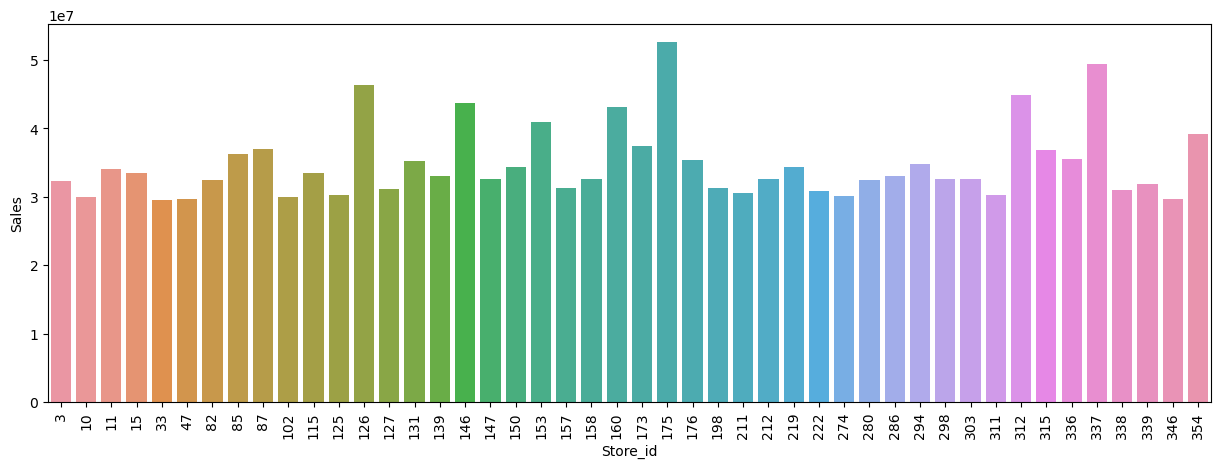

In [31]:
plt.figure(figsize=(15,5),dpi=100)
sns.barplot(s20.index,s20)
plt.xticks(rotation=90)

plt.show()

2) Store_id-wise average sales

In [32]:
smean=df.groupby('Store_id')['Sales'].agg('mean').sort_values(ascending=False)
smean.describe()

count      365.000000
mean     42784.327982
std      13051.704523
min      18693.455233
25%      33852.618663
50%      40640.009302
75%      50561.134360
max     101860.959593
Name: Sales, dtype: float64

In [33]:
print('Store ID with lowest average sales:')
print(smean[-1:].to_string())
print()
print()
print('Store ID with highest average sales:')
print(smean[:1].to_string())


Store ID with lowest average sales:
Store_id
83   18693.455233


Store ID with highest average sales:
Store_id
175   101860.959593


3) Region-wise and Location-wise average Sale

##### Region wise

Region_Code
R1   27.719734
R2   23.742075
R3   24.980704
R4   23.557488


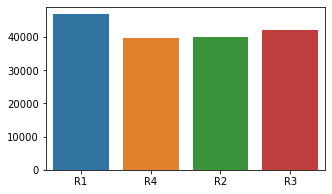

In [34]:
print((df.groupby('Region_Code')['Sales'].mean()/df.groupby('Region_Code')['Sales'].mean().sum()*100
).to_string())


salesregion=pd.Series()

for i in df.Region_Code.unique():
    x=df.groupby('Region_Code')['Sales'].mean()[i]
    salesregion[i]=x
        
plt.figure(figsize=(5,3))   
sns.barplot(salesregion.index,salesregion)
plt.rcParams.update({'font.size':15})

Order of highest average sales: R1,R3,R2,R4

Location Wise

Location_Type
L1   22.048316
L2   31.504006
L3   17.590453
L4   15.460360
L5   13.396866


<AxesSubplot:>

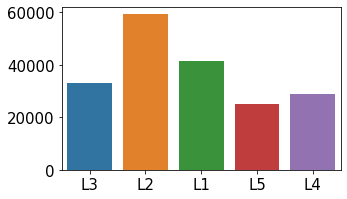

In [35]:
print((df.groupby('Location_Type')['Sales'].mean()/df.groupby('Location_Type')['Sales'].mean().sum()*100).to_string())

salesloc=pd.Series()
for i in df.Location_Type.unique():
    x=df.groupby('Location_Type')['Sales'].mean()[i]
    salesloc[i]=x
    
    
plt.figure(figsize=(5,3))   
sns.barplot(salesloc.index,salesloc)

Order of highest sales: L2,L1,L3,L4,L5

Location_Type
L1   41453.597889
L2   59231.480373
L3   33072.257756
L4   29067.414313
L5   25187.787261
Name: Sales, dtype: float64


<AxesSubplot:xlabel='Location_Type', ylabel='Sales'>

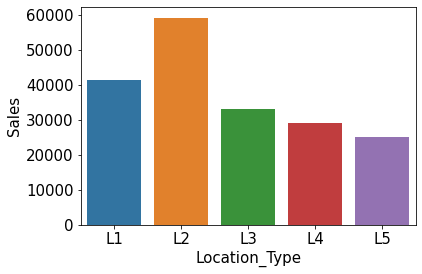

In [36]:
lts=df.groupby('Location_Type')['Sales'].agg('mean')
print(lts)
sns.barplot(lts.index,lts)

##### 3 Store_Type wise

Store_Type
S1   37676.511694
S2   27530.828222
S3   47063.068209
S4   59945.685926
Name: Sales, dtype: float64


<AxesSubplot:xlabel='Store_Type', ylabel='Sales'>

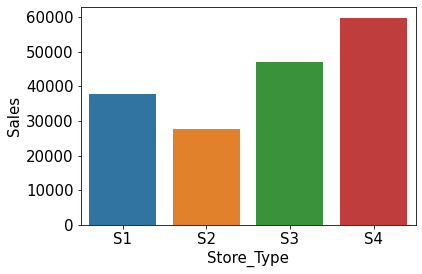

In [37]:
stw=df.groupby('Store_Type')['Sales'].agg('mean')
print(stw)
sns.barplot(stw.index,stw)

4) Region vs Store_id, Location vs Store_id,Store_Type vs Store_id

1.region vs store_id

R1    124
R4     50
R2    105
R3     86


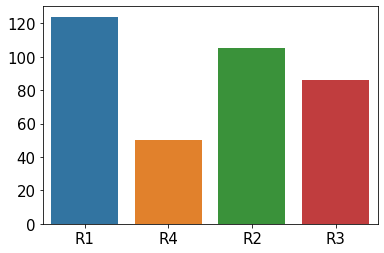

In [38]:
sregion=pd.Series()

for i in df.Region_Code.unique():
    x=df.groupby('Region_Code')['Store_id'].value_counts()[i].count()
    sregion[i]=x
    
print(sregion.to_string())

sns.barplot(sregion.index,sregion)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.show()

2.location vs store _id

L3     58
L2     94
L1    165
L5     27
L4     21


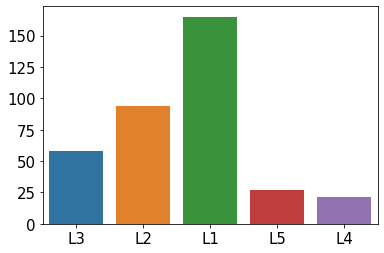

In [39]:
slocation=pd.Series()

for i in df.Location_Type.unique():
    x=df.groupby('Location_Type')['Store_id'].value_counts()[i].count()
    slocation[i]=x
    
print(slocation.to_string())

sns.barplot(slocation.index,slocation)

plt.show()

As number of Stores increases in each Location and Region, the Sales also increases.

###### 3. Store_Type Vs Store_id

S1    172
S4     89
S3     48
S2     56


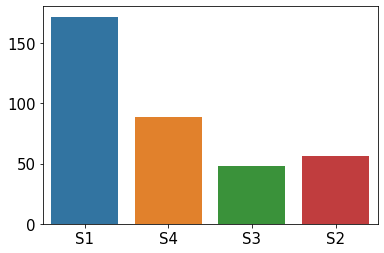

In [40]:
stype=pd.Series()

for i in df.Store_Type.unique():
    x=df.groupby('Store_Type')['Store_id'].value_counts()[i].count()
    stype[i]=x
    
print(stype.to_string())

sns.barplot(stype.index,stype)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.show()

### 5) Average Sales per Month 

Month
1    8.796436
2    7.905668
3    8.014252
4    7.973986
5    9.409868
6    8.742964
7    9.110567
8    7.826663
9    8.042337
10   7.624845
11   7.463024
12   9.089388
Name: Sales, dtype: float64


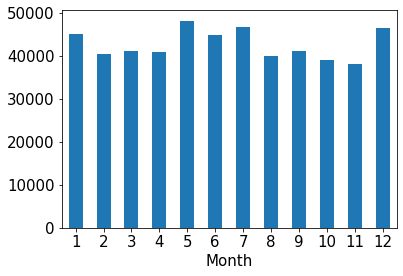

In [41]:
print(df.groupby(['Month'])['Sales'].mean()/np.sum(df.groupby('Month')['Sales'].mean())*100)
df.groupby(['Month'])['Sales'].mean().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

Highest average sales in Jan, May, July and december

### 6) Correlation with Sales and Order

<AxesSubplot:xlabel='Sales', ylabel='Order'>

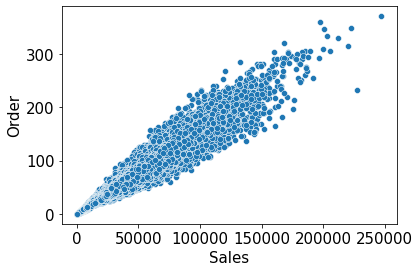

In [42]:
sns.scatterplot(df.Sales,df.Order)

In [43]:
df.corr()

,Order,Sales
Order,1.000000,0.941601
Sales,0.941601,1.000000


Hence strong positive correlation

### 7) Sales on Holidays

In [44]:
df.Holiday.value_counts()

0    163520
1     24820
Name: Holiday, dtype: int64

In [45]:
156881/24251

6.469052822564018

From the above output we can see that the number of holidays is significantly(6 times) less than working days.

<AxesSubplot:xlabel='Holiday', ylabel='Sales'>

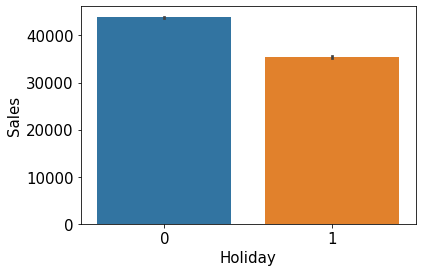

In [46]:
sns.barplot(df.Holiday,df.Sales)

In [47]:
df.groupby('Holiday')['Sales'].mean()

Holiday
0   43897.288998
1   35451.878930
Name: Sales, dtype: float64

From the above graph and average values, we understand that:

Even though the number of holidays is significantly less as compared to working days, the average sales on holidays is NOT as low.
This can mean that, most of the holidays have extremely high sales and only very few holidays have extremely low sales.

### 8) Sales on weekdays and weekends


Let us create a new column as weekend: to check the distribution specifically on weekends vs. weekdays.

In [48]:
df['weekend']=df['day of week'].apply(lambda x:'Weekend' if x in {'Saturday','Sunday'} 
                                      else 'Weekdays')
df.head()

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,Year,Month,Day,day of week,store_cat,weekend
0,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.840000,2018,1,1,Monday,low_sales,Weekdays
1,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.120000,2018,1,1,Monday,high_sales,Weekdays
2,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.200000,2018,1,1,Monday,medium_sales,Weekdays
3,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.160000,2018,1,1,Monday,low_sales,Weekdays
4,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.520000,2018,1,1,Monday,high_sales,Weekdays


<AxesSubplot:xlabel='weekend', ylabel='Sales'>

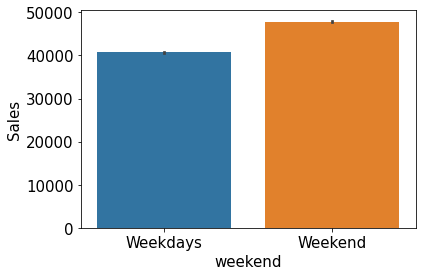

In [49]:
sns.barplot(df.weekend,df.Sales)

Hence it is clear that Sales is higher during weekends.

#### Average sales on holidays with discount

df.groupby(['Holiday','Discount'])['Sales'].mean().unstack('Discount').plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
plt.show()

### 9) Sales vs. Discount

In [50]:
df.Discount.value_counts()

No     104051
Yes     84289
Name: Discount, dtype: int64

<AxesSubplot:xlabel='Discount', ylabel='Sales'>

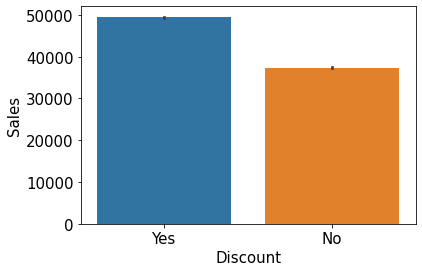

In [51]:
sns.barplot(df.Discount,df.Sales)

**Interpretation:**
       It is visible from the graph that when the store provide a  discount, sale is higher. 

### 10) Store categories vs. Discount

In [52]:
df.groupby('store_cat')['Discount'].value_counts()

store_cat        Discount
high_sales       Yes         35989
                 No          28395
low_sales        No           9164
                 Yes          1626
medium_sales     No          57997
                 Yes         26975
very_high_sales  Yes         19699
                 No           8495
Name: Discount, dtype: int64

In [53]:
df.store_cat.unique()

array(['low_sales', 'high_sales', 'medium_sales', 'very_high_sales'],
      dtype=object)

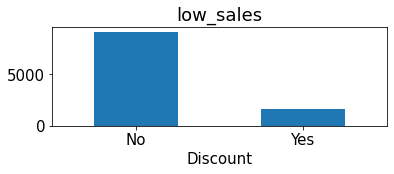

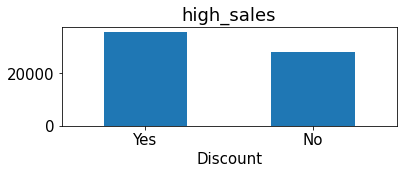

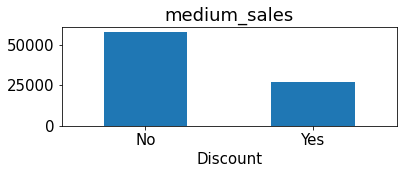

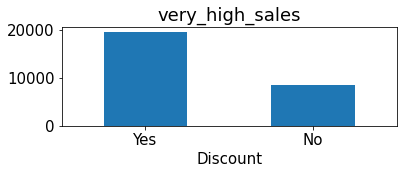

In [54]:
for i in df.store_cat.unique():
    plt.subplot(2,1,1)
    plt.title(i)
    df.groupby('store_cat')['Discount'].value_counts()[i].plot(kind='bar')
    plt.xticks(rotation=0)
    plt.show()

**Interpretation**: Very high sales stores and high sales have higher discount compared to medium and low sales store

### 11) Day of Month vs. Discount 

Days of the month with higher discounts:  [1, 2, 3, 4, 13, 14, 15, 16]


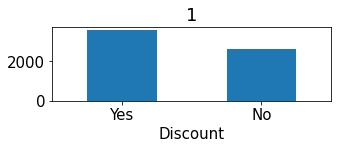

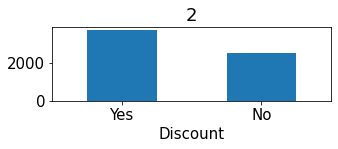

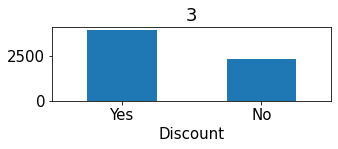

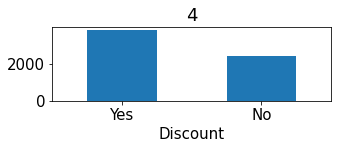

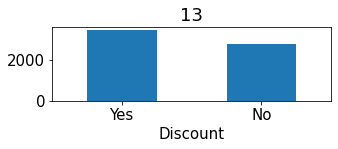

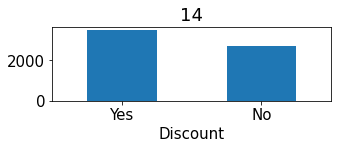

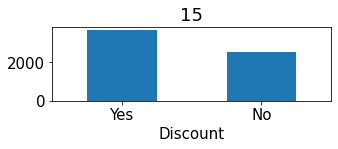

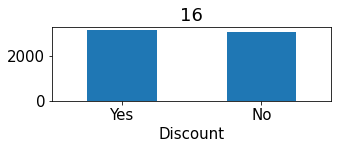

In [55]:
Days=[]
for i in df.Day.unique():
    if df.groupby('Day')['Discount'].value_counts()[i]['Yes']>df.groupby('Day')['Discount'].value_counts()[i]['No']:
        Days.append(i)
print('Days of the month with higher discounts: ',Days)  


for i in df.Day.unique():
    if df.groupby('Day')['Discount'].value_counts()[i]['Yes']>df.groupby('Day')['Discount'].value_counts()[i]['No']:
        plt.figure(figsize=(5,3))
        plt.subplot(2,1,1)
        plt.title(i)
        df.groupby('Day')['Discount'].value_counts()[i].plot(kind='bar')
        plt.xticks(rotation=0)
        plt.show()

**Interpretation**: From the above graph we can find a pattern of discount in day of month.

Begining of the month they provide discount, because during these days people get their salaries and store can increase their sales.

Next pattern is during mid month days to boost up the sales which have faced a drastic decrease after the first 5 days of the month.

### 12) Sales on each day of the month

<AxesSubplot:xlabel='Day', ylabel='Sales'>

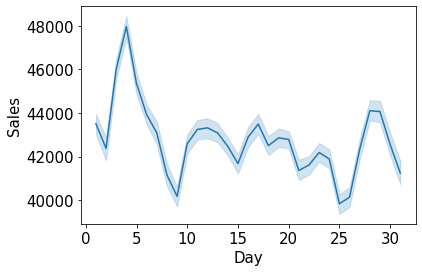

In [56]:
sns.lineplot(df.Day,df.Sales)

**Interpretation:** The amount of sales is highest in the first 5 days of the month.

This is mainly because the customers receive their salaries during month-end/month-beginning.

### Distribution Holidays Sales Vs Non-Holidays

In [57]:
dec25=df[df.Month==12]
dec25.head()

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,Year,Month,Day,day of week,store_cat,weekend
121910,201,S4,L1,R1,2018-12-01,0,No,100,49875.000000,2018,12,1,Saturday,high_sales,Weekend
121911,147,S4,L2,R4,2018-12-01,0,No,89,48033.000000,2018,12,1,Saturday,high_sales,Weekend
121912,323,S1,L4,R1,2018-12-01,0,No,62,35034.000000,2018,12,1,Saturday,medium_sales,Weekend
121913,49,S4,L1,R2,2018-12-01,0,No,94,48315.000000,2018,12,1,Saturday,high_sales,Weekend
121914,341,S1,L1,R2,2018-12-01,0,No,81,48747.000000,2018,12,1,Saturday,high_sales,Weekend


<AxesSubplot:xlabel='Day', ylabel='Sales'>

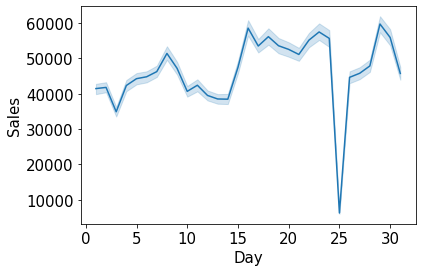

In [58]:
sns.lineplot(dec25.Day,dec25.Sales)

In [59]:
aug15=df[(df.Month==8)&(df.Day==15)]
aug15

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,Year,Month,Day,day of week,store_cat,weekend
82490,229,S1,L1,R2,2018-08-15,1,No,35,19621.800000,2018,8,15,Wednesday,low_sales,Weekdays
82491,233,S1,L3,R3,2018-08-15,1,No,27,15180.480000,2018,8,15,Wednesday,low_sales,Weekdays
82492,169,S1,L2,R4,2018-08-15,1,No,30,18286.380000,2018,8,15,Wednesday,low_sales,Weekdays
82493,90,S1,L1,R3,2018-08-15,1,No,28,15991.440000,2018,8,15,Wednesday,low_sales,Weekdays
82494,291,S1,L3,R1,2018-08-15,1,No,32,16509.600000,2018,8,15,Wednesday,low_sales,Weekdays
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82850,207,S1,L1,R3,2018-08-15,1,No,48,32348.550000,2018,8,15,Wednesday,medium_sales,Weekdays
82851,133,S1,L1,R4,2018-08-15,1,No,45,25067.520000,2018,8,15,Wednesday,medium_sales,Weekdays
82852,75,S3,L2,R3,2018-08-15,1,No,46,29345.400000,2018,8,15,Wednesday,medium_sales,Weekdays
82853,160,S4,L2,R1,2018-08-15,1,No,94,46896.300000,2018,8,15,Wednesday,high_sales,Weekdays


In [60]:
may1=df[df.Month==5]
may1

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,Year,Month,Day,day of week,store_cat,weekend
43800,17,S1,L1,R2,2018-05-01,0,Yes,75,46104.000000,2018,5,1,Tuesday,high_sales,Weekdays
43801,254,S4,L1,R1,2018-05-01,0,Yes,85,57351.000000,2018,5,1,Tuesday,high_sales,Weekdays
43802,164,S1,L1,R3,2018-05-01,0,Yes,52,38184.000000,2018,5,1,Tuesday,medium_sales,Weekdays
43803,47,S4,L2,R2,2018-05-01,0,Yes,113,71076.000000,2018,5,1,Tuesday,very_high_sales,Weekdays
43804,213,S1,L1,R2,2018-05-01,0,Yes,69,47079.000000,2018,5,1,Tuesday,high_sales,Weekdays
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188335,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.000000,2019,5,31,Friday,medium_sales,Weekdays
188336,153,S4,L2,R1,2019-05-31,1,No,90,54572.640000,2019,5,31,Friday,high_sales,Weekdays
188337,154,S1,L3,R2,2019-05-31,1,No,56,31624.560000,2019,5,31,Friday,medium_sales,Weekdays
188338,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.410000,2019,5,31,Friday,high_sales,Weekdays


<AxesSubplot:xlabel='Day', ylabel='Sales'>

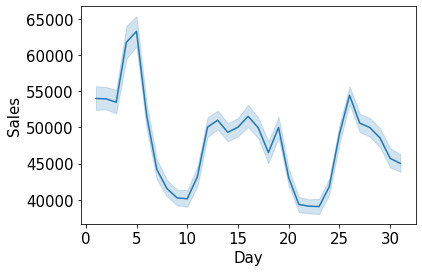

In [61]:
may1=df[df.Month==5]
sns.lineplot(may1.Day,may1.Sales)

<AxesSubplot:xlabel='Day', ylabel='Sales'>

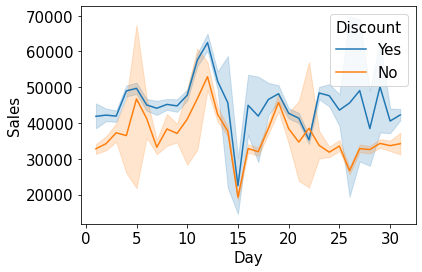

In [62]:
aug1=df[df.Month==8]
sns.lineplot(aug1.Day,aug1.Sales,hue=df.Discount)

<AxesSubplot:xlabel='Day', ylabel='Sales'>

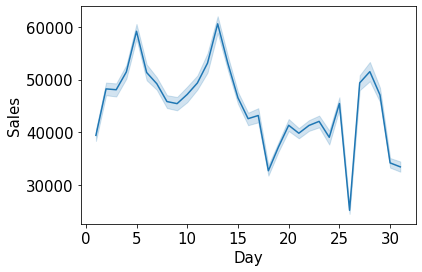

In [63]:
newy1=df[df.Month==1]
sns.lineplot(newy1.Day,newy1.Sales)

13) Distribution of Sales in Store Type

In [64]:
dfa = df.groupby('Store_Type')['Sales'].agg('mean').sort_values(ascending=False)
dfa

Store_Type
S4   59945.685926
S3   47063.068209
S1   37676.511694
S2   27530.828222
Name: Sales, dtype: float64

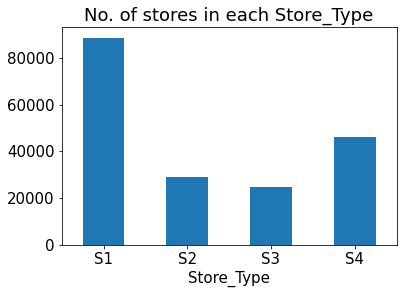

In [65]:
df.groupby('Store_Type')['Store_id'].count().plot(kind='bar')
plt.title('No. of stores in each Store_Type')
plt.xticks(rotation=0)
plt.show()

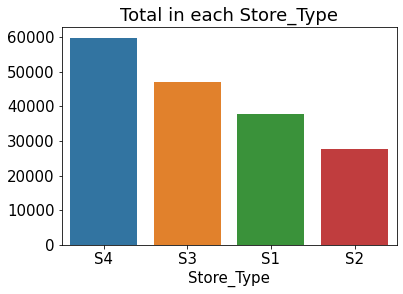

In [66]:
sns.barplot(dfa.index,dfa.values)
plt.title('Total in each Store_Type')
plt.show()

Overall, S4 has the highest average sales, followed by S3, S1 then S2.

#### Region-wise and Location-wise distribution of Store_Type

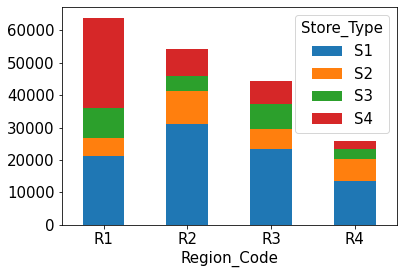

In [67]:
df.groupby(['Region_Code','Store_Type'])['Region_Code'].count().sort_values(ascending=False).unstack(
    'Store_Type').plot(kind='bar',stacked=True)
plt.xticks(rotation=0)
plt.show()

R1 has S4 the most, hence

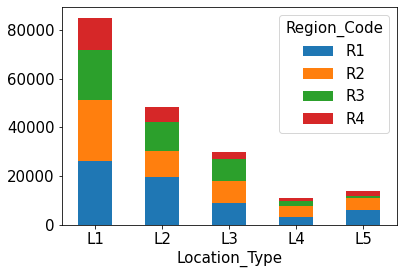

In [68]:
df.groupby(['Location_Type','Region_Code'])['Location_Type'].count().sort_values(ascending=False).unstack(
    'Region_Code').plot(kind='bar',stacked=True)
plt.xticks(rotation=0)
plt.show()

In [69]:
df.groupby('Location_Type')['Store_id'].count()

Location_Type
L1    85140
L2    48504
L3    29928
L4    10836
L5    13932
Name: Store_id, dtype: int64

There are all 4 regions present in all the Locations
L1 is the biggest location with 85000 stores (next in line is L2 with almost half the number of stores)
L4 has the lowest

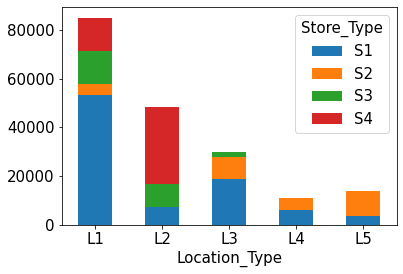

In [70]:
df.groupby(['Location_Type','Store_Type'])['Location_Type'].count().sort_values(ascending=False).unstack(
    'Store_Type').plot(kind='bar',stacked=True)
plt.xticks(rotation=0)
plt.show()

L1 is the only location that has all the store types, since it is the biggest and covers all the regions

In [71]:
S4=df[df['Store_Type']=='S4']
S4.head()

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,Year,Month,Day,day of week,store_cat,weekend
1,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.120000,2018,1,1,Monday,high_sales,Weekdays
9,254,S4,L1,R1,2018-01-01,1,Yes,87,62572.800000,2018,1,1,Monday,very_high_sales,Weekdays
10,245,S4,L1,R2,2018-01-01,1,Yes,36,27468.210000,2018,1,1,Monday,medium_sales,Weekdays
11,11,S4,L2,R1,2018-01-01,1,Yes,69,57590.400000,2018,1,1,Monday,high_sales,Weekdays
12,243,S4,L2,R2,2018-01-01,1,Yes,69,45563.250000,2018,1,1,Monday,high_sales,Weekdays


In [72]:
S4.groupby(['Store_Type','Discount','Holiday'])['Sales'].agg(['max','min','mean'])

max          min         mean
Store_Type Discount Holiday                                        
S4         No       0       184992.000000     0.000000 54101.021338
                    1       197840.610000     0.000000 44746.129793
           Yes      0       247215.000000 17643.000000 70812.532334
                    1       165602.280000  2270.460000 54642.653500

<AxesSubplot:xlabel='Discount', ylabel='Sales'>

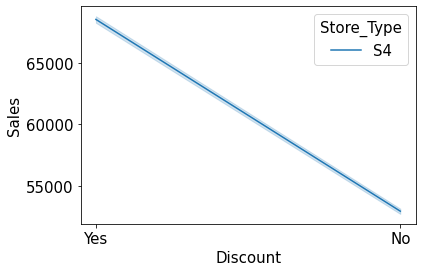

In [73]:
sns.lineplot(S4.Discount,S4.Sales,hue=S4.Store_Type)

<AxesSubplot:xlabel='Location_Type', ylabel='Sales'>

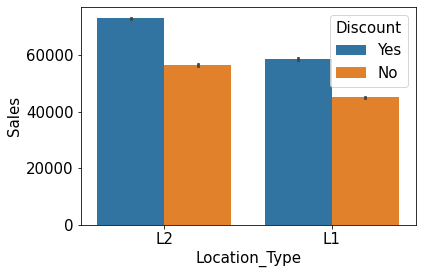

In [74]:
sns.barplot(S4.Location_Type,S4.Sales,hue=S4.Discount)

<AxesSubplot:xlabel='Location_Type', ylabel='Sales'>

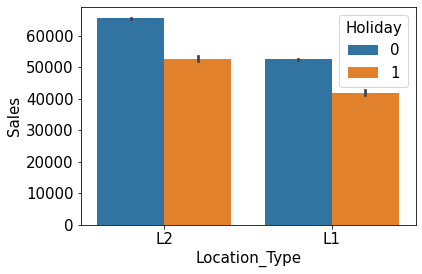

In [75]:
sns.barplot(S4.Location_Type,S4.Sales,hue=S4.Holiday)

<AxesSubplot:xlabel='Location_Type', ylabel='Sales'>

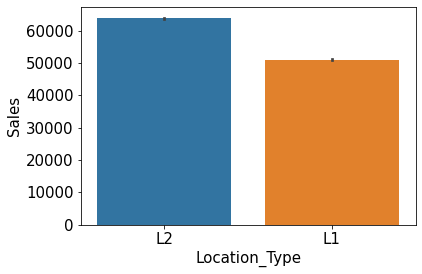

In [76]:
sns.barplot(S4.Location_Type,S4.Sales)

<AxesSubplot:xlabel='Location_Type', ylabel='Sales'>

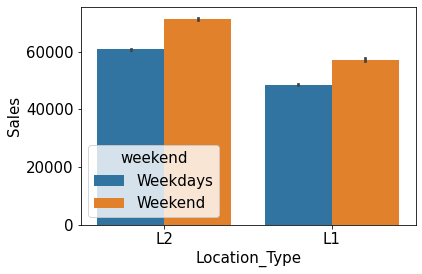

In [77]:
sns.barplot(S4.Location_Type,S4.Sales,hue=S4.weekend)

<AxesSubplot:xlabel='Region_Code', ylabel='Sales'>

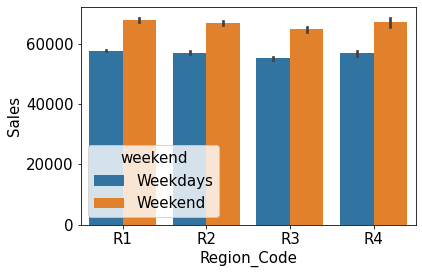

In [78]:
sns.barplot(S4.Region_Code,S4.Sales,hue=S4.weekend)

<AxesSubplot:xlabel='Day', ylabel='Sales'>

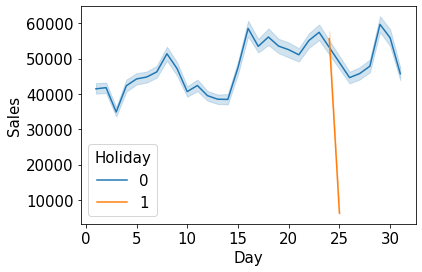

In [79]:
dec25=df[df.Month==12]
sns.lineplot(dec25.Day,dec25.Sales,hue=dec25.Holiday)

<AxesSubplot:xlabel='Month', ylabel='Sales'>

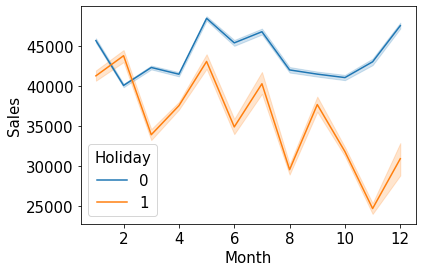

In [80]:
sns.lineplot(df['Month'],df['Sales'],hue=df['Holiday'])

<AxesSubplot:xlabel='Day', ylabel='Sales'>

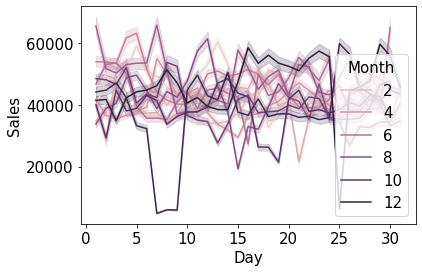

In [81]:
sns.lineplot(df['Day'],df['Sales'],hue=df['Month'])

<AxesSubplot:xlabel='Store_Type', ylabel='Sales'>

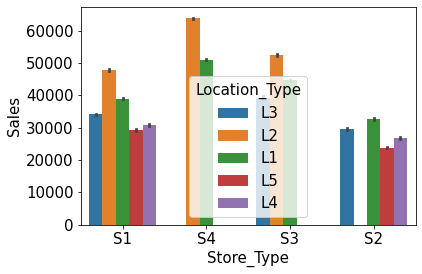

In [82]:
sns.barplot(df['Store_Type'],df['Sales'],hue=df['Location_Type'])

In [83]:
df.groupby(['Store_Type','Discount','Holiday'])['Sales'].agg(['max','min','mean'])

max          min         mean
Store_Type Discount Holiday                                        
S1         No       0       117669.000000     0.000000 33563.783012
                    1       100383.030000     0.000000 27776.443309
           Yes      0       143841.000000 10014.000000 45030.695828
                    1       115665.300000  2088.960000 35234.512707
S2         No       0        74157.000000  3957.000000 24567.326724
                    1        68461.140000  1748.280000 20201.534746
           Yes      0        96363.000000  9333.000000 32826.049878
                    1        86203.200000  1969.140000 26220.928304
S3         No       0       130287.000000     0.000000 41656.089879
                    1        99384.000000  3314.070000 34708.702548
           Yes      0       166323.000000 14796.000000 56554.485920
                    1       117282.240000  3765.930000 43562.849536
S4         No       0       184992.000000     0.000000 54101.021338
                    1       197840.610000     0.000000 44746.129793
           Yes      0       247215.000000 17643.000000 70812.532334
                    1       165602.280000  2270.460000 54642.653500

### MULTIVARIATE ANALYSIS

### 1) 2 categorical vs. 1 numerical
- weekend (categorical)
- Discount (categorical)
- Order (numerical)

<AxesSubplot:xlabel='weekend', ylabel='Order'>

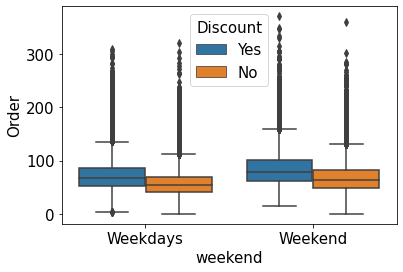

In [84]:
sns.boxplot(df.weekend,df.Order , hue=df.Discount)

weekend sightly higher with discount

## 2) 2 numerical vs. 1 categorical
- Holiday (categorical)
- Sales (numerical)
- Order (numerical)

<AxesSubplot:xlabel='Order', ylabel='Sales'>

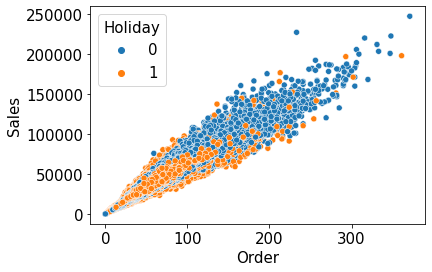

In [85]:
sns.scatterplot(df.Order,df.Sales, hue=df.Holiday)

### Statistical Tests

In [86]:
import scipy.stats as stats

In [87]:
(stat, pvalue)=stats.ttest_ind(df[df.Holiday==1].Sales,df[df.Holiday==0]['Sales'])
print('pvalue of Holiday=',pvalue)

(stat, pvalue)=stats.ttest_ind(df[df.Discount=='Yes'].Sales,df[df.Discount=='No'].Sales )
print('pvalue of Discount=',pvalue)

(stat, pvalue)=stats.f_oneway(df[df.Store_Type=='S1'].Sales,df[df.Store_Type=='S2'].Sales,df[df.Store_Type=='S3'].Sales,
               df[df.Store_Type=='S4'].Sales)
print('pvalue of Store Type=',pvalue)

(stat, pvalue)=stats.f_oneway(df[df.Location_Type=='L1'].Sales,df[df.Location_Type=='L2'].Sales,
                              df[df.Location_Type=='L3'].Sales,df[df.Location_Type=='L4'].Sales,
                              df[df.Location_Type=='L5'].Sales)
print('pvalue of Location Type=',pvalue)

(stat, pvalue)=stats.f_oneway(df[df.Region_Code=='R1'].Sales,df[df.Region_Code=='R2'].Sales,df[df.Region_Code=='R3'].Sales,
              df[df.Region_Code=='R4'].Sales)
print('pvalue of Region Code=',pvalue)



pvalue of Holiday= 0.0
pvalue of Discount= 0.0
pvalue of Store Type= 0.0
pvalue of Location Type= 0.0
pvalue of Region Code= 0.0


number of orders and sales decreases when there is a holiday

## MODEL BUILDING
## Splitting dataset into categorical and numerical

In [88]:
def weekom(x):
    if x<=7:
        return 'week1'
    elif 7<x<=14:
        return 'week2'
    elif 14<x<=21:
        return 'week3'
    elif 21<x<=28:
        return 'week4'
    else:
        return 'week5'

In [89]:
df['week_of_month']=df['Day'].apply(weekom)
df.head()

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,Year,Month,Day,day of week,store_cat,weekend,week_of_month
0,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.840000,2018,1,1,Monday,low_sales,Weekdays,week1
1,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.120000,2018,1,1,Monday,high_sales,Weekdays,week1
2,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.200000,2018,1,1,Monday,medium_sales,Weekdays,week1
3,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.160000,2018,1,1,Monday,low_sales,Weekdays,week1
4,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.520000,2018,1,1,Monday,high_sales,Weekdays,week1


###  Encoding


In [90]:
dfc=df.select_dtypes(include='object')
dfc.head()

,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,Year,Month,Day,day of week,store_cat,weekend,week_of_month
0,1,S1,L3,R1,1,Yes,2018,1,1,Monday,low_sales,Weekdays,week1
1,253,S4,L2,R1,1,Yes,2018,1,1,Monday,high_sales,Weekdays,week1
2,252,S3,L2,R1,1,Yes,2018,1,1,Monday,medium_sales,Weekdays,week1
3,251,S2,L3,R1,1,Yes,2018,1,1,Monday,low_sales,Weekdays,week1
4,250,S2,L3,R4,1,Yes,2018,1,1,Monday,high_sales,Weekdays,week1


In [91]:
# dummy variable trap
encoded_data = pd.get_dummies(dfc.drop(['Store_id','Day','day of week','store_cat'],axis=1),drop_first=True)
print(encoded_data.shape)
encoded_data.head()

(188340, 29)


,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R2,Region_Code_R3,Region_Code_R4,Holiday_1,Discount_Yes,Year_2019,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,weekend_Weekend,week_of_month_week2,week_of_month_week3,week_of_month_week4,week_of_month_week5
0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
df_base = pd.concat([dfn,encoded_data],axis=1)
df_base.head()

,Order,Sales,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R2,Region_Code_R3,Region_Code_R4,Holiday_1,Discount_Yes,Year_2019,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,weekend_Weekend,week_of_month_week2,week_of_month_week3,week_of_month_week4,week_of_month_week5
0,9,7011.840000,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,60,51789.120000,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,42,36868.200000,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,23,19715.160000,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,62,45614.520000,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Assigning target and independent variables

In [93]:
features = df_base.drop('Sales',axis=1)

target = df_base['Sales']

features = sm.add_constant(features)

#### Splitting data into train and split

In [94]:
xtrain,xtest,ytrain,ytest = train_test_split(features,target,test_size=.20,random_state=10)

### Base model

In [95]:
mlr_model = sm.OLS(ytrain, xtrain).fit()

In [96]:
 print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                 8.160e+04
Date:                Sat, 14 May 2022   Prob (F-statistic):               0.00
Time:                        01:48:02   Log-Likelihood:            -1.4796e+06
No. Observations:              150672   AIC:                         2.959e+06
Df Residuals:                  150641   BIC:                         2.960e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5812.7807    

In [97]:
ypred_train= mlr_model.predict(xtrain)
ypred_test= mlr_model.predict(xtest)

print('Model Evaluation')
mse_train= mean_squared_error(ytrain,ypred_train)
mse_test= mean_squared_error(ytest,ypred_test)

rmse_train=np.sqrt(mse_train)
rmse_test=np.sqrt(mse_test)


print('RMSE train:',rmse_train)
print('RMSE test:',rmse_test)

def mape(actual,predicted):
    return (np.mean(np.abs((actual - predicted)/actual))*100)

print('MAPE on  training data set: ', mape(ytrain,ypred_train))
print('MAPE on  test data set: ', mape(ytest,ypred_test))

Model Evaluation
RMSE train: 4452.752057747908
RMSE test: 4463.463521101094
MAPE on  training data set:  inf
MAPE on  test data set:  inf


### Treating the outliers

Upper Limit 82719.0
Lower Limit -633.0


<AxesSubplot:>

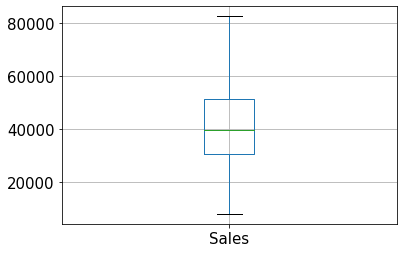

In [98]:

df3=df.drop('Date',axis=1)
Q1=df3.quantile(0.25)
Q3=df3.quantile(0.75)
IQR=Q3-Q1
df3=df3[~((df3>(Q3+(2.5*IQR)))).any(axis=1)]

df3=df3[df3.Sales>8000]

q1=df3['Sales'].quantile(0.25)
q3=df3['Sales'].quantile(0.75)

IQR=q3-q1

UL=q3+(1.5*IQR)
print('Upper Limit',UL)
LL=q1-(1.5*IQR)
print('Lower Limit',LL)

a=np.array(df3['Sales'].values.tolist())

df3['Sales']=np.where(a<LL,LL,a).tolist()
df3['Sales']=np.where(a>UL,UL,a).tolist()
df3.boxplot('Sales')




Upper Limit 130.5
Lower Limit -1.5


<AxesSubplot:>

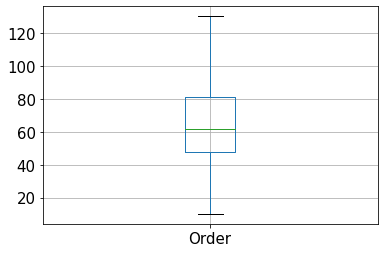

In [99]:
q1=df3['Order'].quantile(0.25)
q3=df3['Order'].quantile(0.75)

IQR=q3-q1

UL=q3+(1.5*IQR)
print('Upper Limit',UL)
LL=q1-(1.5*IQR)
print('Lower Limit',LL)

a=np.array(df3['Order'].values.tolist())

df3['Order']=np.where(a<LL,LL,a).tolist()
df3['Order']=np.where(a>UL,UL,a).tolist()
df3.boxplot('Order')

In [100]:
df4=df3.copy()
dfdate=df['Date']
df=pd.concat([dfdate,df3], axis=1)
df.dropna(inplace=True)
df.head()

,Date,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,Order,Sales,Year,Month,Day,day of week,store_cat,weekend,week_of_month
1,2018-01-01,253,S4,L2,R1,1,Yes,60.000000,51789.120000,2018,1,1,Monday,high_sales,Weekdays,week1
2,2018-01-01,252,S3,L2,R1,1,Yes,42.000000,36868.200000,2018,1,1,Monday,medium_sales,Weekdays,week1
3,2018-01-01,251,S2,L3,R1,1,Yes,23.000000,19715.160000,2018,1,1,Monday,low_sales,Weekdays,week1
4,2018-01-01,250,S2,L3,R4,1,Yes,62.000000,45614.520000,2018,1,1,Monday,high_sales,Weekdays,week1
5,2018-01-01,249,S1,L3,R2,1,Yes,39.000000,34211.220000,2018,1,1,Monday,medium_sales,Weekdays,week1


In [101]:
df.shape

(183851, 16)

### after treating outliers building models

In [102]:
dfc=df.select_dtypes(include='object')
dfn= df.select_dtypes(include = 'number')

encoded_data = pd.get_dummies(dfc.drop(['Store_id','Day','day of week','store_cat'],axis=1),drop_first=True)
print(encoded_data.shape)
encoded_data.head()

(183851, 29)


,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R2,Region_Code_R3,Region_Code_R4,Holiday_1,Discount_Yes,Year_2019,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,weekend_Weekend,week_of_month_week2,week_of_month_week3,week_of_month_week4,week_of_month_week5
1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
df_base = pd.concat([dfn,encoded_data],axis=1)
df_base.head()

,Order,Sales,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R2,Region_Code_R3,Region_Code_R4,Holiday_1,Discount_Yes,Year_2019,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,weekend_Weekend,week_of_month_week2,week_of_month_week3,week_of_month_week4,week_of_month_week5
1,60.000000,51789.120000,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,42.000000,36868.200000,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,23.000000,19715.160000,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,62.000000,45614.520000,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,39.000000,34211.220000,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [104]:
features = df_base.drop(['Sales','Order'],axis=1)
target = df_base['Sales']
features = sm.add_constant(features)

In [105]:
# spliting 70:30

xtrain,xtest,ytrain,ytest = train_test_split(features,target,test_size=.30,random_state=10)
print(xtrain.shape)
print(ytrain.shape)

(128695, 30)
(128695,)


#### building an ols model

In [106]:
B_model1 = sm.OLS(ytrain, xtrain).fit()
print(B_model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     7701.
Date:                Sat, 14 May 2022   Prob (F-statistic):               0.00
Time:                        01:48:06   Log-Likelihood:            -1.3618e+06
No. Observations:              128695   AIC:                         2.724e+06
Df Residuals:                  128665   BIC:                         2.724e+06
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3.608e+04    

In [107]:
# Prediction
ypred_train= B_model1.predict(xtrain)
ypred_test= B_model1.predict(xtest)

# Model evaluation
mse_train= mean_squared_error(ytrain,ypred_train)
mse_test= mean_squared_error(ytest,ypred_test)

#rmse
rmse_train=np.sqrt(mse_train)
rmse_test=np.sqrt(mse_test)


print('RMSE train:',rmse_train)
print('RMSE test:',rmse_test)

print('MAPE on  training data set: ', mape(ytrain,ypred_train))
print('MAPE on  test data set: ', mape(ytest,ypred_test))

RMSE train: 9534.440247681703
RMSE test: 9547.42199063175
MAPE on  training data set:  19.006579549252756
MAPE on  test data set:  19.212842176629547


### building a model using transformation

In [108]:
y1=np.log(df_base['Sales'])
x1=df_base.drop(['Sales','Order'],axis=1)
x1=sm.add_constant(x1)

In [109]:
xtrain1,xtest1,ytrain1,ytest1 = train_test_split(x1,y1,test_size=.30,random_state=10)

print(xtrain1.shape)
print(ytrain1.shape)

(128695, 30)
(128695,)


In [110]:
B_model2=sm.OLS(ytrain1,xtrain1).fit()
print(B_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     7649.
Date:                Sat, 14 May 2022   Prob (F-statistic):               0.00
Time:                        01:48:07   Log-Likelihood:                 3761.3
No. Observations:              128695   AIC:                            -7463.
Df Residuals:                  128665   BIC:                            -7170.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.4615    

In [111]:
# Prediction
ypred_train1= B_model2.predict(xtrain1)
ypred_test1= B_model2.predict(xtest1)

# use exponential the data
ytrain_predexp=np.exp(ypred_train1)
ytest_predexp=np.exp(ypred_test1)
y_trainex=np.exp(ytrain1)
y_testex=np.exp(ytest1)

#Mse
mse_train1=mean_squared_error(y_trainex,ytrain_predexp)
mse_test1=mean_squared_error(y_testex,ytest_predexp)
print('Train mse',mse_train1)
print('Test mse',mse_test1)


#RMSE
print('Train rmse',np.sqrt(mse_train1))
print('Test rmse',np.sqrt(mse_test1))


#mape
print('Mape_train:',mape(y_trainex,ytrain_predexp))
print('Mape_test:',mape(y_testex,ytest_predexp))

Train mse 90984730.87217088
Test mse 90970343.64062989
Train rmse 9538.591660836042
Test rmse 9537.837471913112
Mape_train: 18.038110476784034
Mape_test: 18.22396230015726


### building model on backward feature selection 

In [112]:
x2 = df_base.drop(['Sales','Order'],axis=1)
y2 = df_base['Sales']
x2 = sm.add_constant(x2)

In [113]:
xtrain2,xtest2,ytrain2,ytest2 = train_test_split(x2,y2,test_size=.30,random_state=10)

print(xtrain2.shape)
print(ytrain2.shape)

(128695, 30)
(128695,)


In [114]:
linreg=LinearRegression()
back_lin=sfs(estimator=linreg,k_features='best',forward=True,verbose=2,scoring='r2')
sfs_back=back_lin.fit(xtrain2,ytrain2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.5s finished

[2022-05-14 01:48:10] Features: 1/30 -- score: 0.2739075861669373[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    3.9s finished

[2022-05-14 01:48:14] Features: 2/30 -- score: 0.3934803953060395[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    4.3s finished

[2022-05-14 01:48:18] Features: 3/30 -- score: 0.4718075245073049[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [115]:
sfs_back.k_feature_names_

('Store_Type_S2',
 'Store_Type_S3',
 'Store_Type_S4',
 'Location_Type_L2',
 'Location_Type_L3',
 'Location_Type_L4',
 'Location_Type_L5',
 'Region_Code_R3',
 'Region_Code_R4',
 'Holiday_1',
 'Discount_Yes',
 'Year_2019',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Month_10',
 'Month_11',
 'Month_12',
 'weekend_Weekend',
 'week_of_month_week2',
 'week_of_month_week3',
 'week_of_month_week4',
 'week_of_month_week5')

In [116]:
# building a base model using the feature selection of backward

In [117]:
y3=df_base['Sales']
x3=df_base.drop(['Sales','Order','Region_Code_R2','Region_Code_R3',],axis=1)
x3=sm.add_constant(x3)

In [118]:
xtrain3,xtest3,ytrain3,ytest3 = train_test_split(x3,y3,test_size=.30,random_state=10)

print(xtrain3.shape)
print(ytrain3.shape)

(128695, 28)
(128695,)


In [119]:
Bf_M1=sm.OLS(ytrain3,xtrain3).fit()
print(Bf_M1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     8270.
Date:                Sat, 14 May 2022   Prob (F-statistic):               0.00
Time:                        01:50:13   Log-Likelihood:            -1.3618e+06
No. Observations:              128695   AIC:                         2.724e+06
Df Residuals:                  128667   BIC:                         2.724e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  3.6e+04    

In [120]:
# Prediction
ypred_train3= Bf_M1.predict(xtrain3)
ypred_test3= Bf_M1.predict(xtest3)

# Model evaluation
mse_train3= mean_squared_error(ytrain3,ypred_train3)
mse_test3= mean_squared_error(ytest3,ypred_test3)

#rmse
rmse_train3=np.sqrt(mse_train3)
rmse_test3=np.sqrt(mse_test3)


print('RMSE train:',rmse_train3)
print('RMSE test:',rmse_test3)

print('MAPE on  training data set: ', mape(ytrain3,ypred_train3))
print('MAPE on  test data set: ', mape(ytest3,ypred_test3))

RMSE train: 9534.872118508567
RMSE test: 9547.10898660549
MAPE on  training data set:  19.00406071688428
MAPE on  test data set:  19.21032760419812


In [121]:
# Building model using Elastic net Regression

elastic=ElasticNet(alpha=0.01).fit(xtrain, ytrain)


ypred_train = elastic.predict(xtrain)
ypred_test = elastic.predict(xtest)


score = elastic.score(xtest, ytest)

mse_train = mean_squared_error(ytrain, ypred_train)
mse_test = mean_squared_error(ytest, ypred_test)


rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print('R2: ', score)
print('RMSE train:',rmse_train)
print('RMSE test:',rmse_test)

R2:  0.6325379461786216
RMSE train: 9544.705103867818
RMSE test: 9558.686547873742


In [122]:
parametersGrid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                 "l1_ratio": np.arange(0.0, 1.0, 0.1)}

eNet = ElasticNet()
grid = GridSearchCV(eNet, parametersGrid, scoring='accuracy', cv=10)
grid.fit(xtrain, ytrain)
print('Best parameters for Elastic Net Regression: ', grid.best_params_, '\n')


Best parameters for Elastic Net Regression:  {'alpha': 0.0001, 'l1_ratio': 0.0} 



In [123]:
# Elastic net regression after GridSearch

elastic=ElasticNet(alpha=0.0001,l1_ratio=0.0).fit(xtrain, ytrain)

ypred_train = elastic.predict(xtrain)
ypred_test = elastic.predict(xtest)

score = elastic.score(xtest, ytest)

mse_train = mean_squared_error(ytrain, ypred_train)
mse_test = mean_squared_error(ytest, ypred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print('R2: ', score)
print('RMSE train:',rmse_train)
print('RMSE test:',rmse_test)

R2:  0.6334005055308124
RMSE train: 9534.446893488874
RMSE test: 9547.46120025024


<AxesSubplot:>

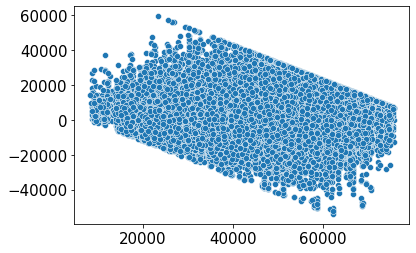

In [124]:
fitted = B_model1.fittedvalues
residual = B_model1.resid
sns.scatterplot(fitted,residual)

<AxesSubplot:>

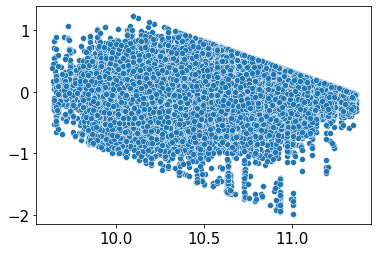

In [125]:
fitted1 = B_model2.fittedvalues
residual1 = B_model2.resid
sns.scatterplot(fitted1,residual1)

### SGD Regressor

In [126]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(random_state = 10)

linreg_with_SGD = sgd.fit(xtrain, ytrain)

test_pred = linreg_with_SGD.predict(xtest)
train_pred= linreg_with_SGD.predict(xtrain)
# RMSE Computation
rmse_test = np.sqrt(mean_squared_error(ytest, test_pred))
rmse_train = np.sqrt(mean_squared_error(ytrain, train_pred))
print("rmse test:",rmse_test)
print("rmse train:",rmse_train)
print('MAPE_train:',mape(ytrain,train_pred))
print('MAPE_test:',mape(ytest,test_pred))
print('score:',linreg_with_SGD.score(xtrain,ytrain))

rmse test: 9548.604830217619
rmse train: 9535.614353538012
MAPE_train: 19.084536341103657
MAPE_test: 19.29257912373875
score: 0.6343665573514028


### Random Forest Regressor

In [127]:
rf=RandomForestRegressor()
rf_model=rf.fit(xtrain,ytrain)

In [128]:
rfpred_train=rf_model.predict(xtrain)
rfpred_test=rf_model.predict(xtest)

In [129]:
rf_test_rmse = np.sqrt(mean_squared_error(ytest, rfpred_test))
rf_train_rmse = np.sqrt(mean_squared_error(ytrain, rfpred_train)) 
print('RMSE train:',rf_train_rmse)
print('RMSE test:',rf_test_rmse)

RMSE train: 7696.434467126658
RMSE test: 8576.462735929057


In [130]:
# Mape
def mape(actual,predicted):
    return (np.mean(np.abs((actual-predicted)/actual))*100)

In [131]:
print('MAPE on  rf_training data set: ', mape(ytrain,rfpred_train))
print('MAPE on  rf_test data set: ', mape(ytest,rfpred_test))

MAPE on  rf_training data set:  14.8228693226085
MAPE on  rf_test data set:  16.87111227452748


In [132]:
fea_impo=rf_model.feature_importances_

In [133]:
fea_import=pd.DataFrame({'Features':xtrain.columns,
                        'Importance':rf_model.feature_importances_})
fea_import=fea_import.sort_values('Importance',ascending=False)

<AxesSubplot:xlabel='Importance', ylabel='Features'>

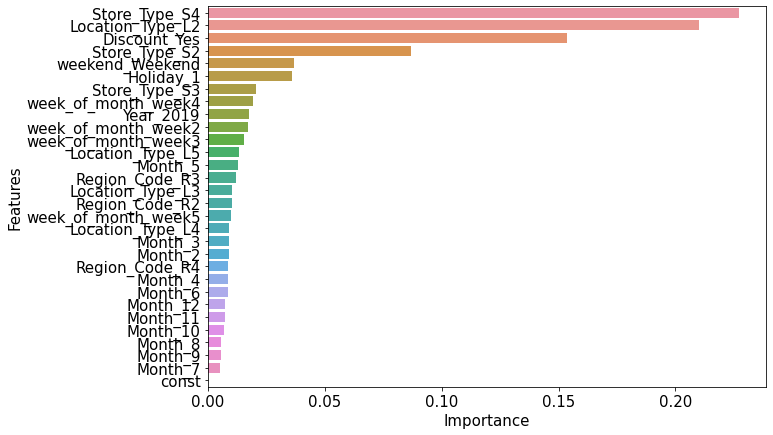

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
sns.barplot(fea_import['Importance'],fea_import['Features'])

In [135]:
top_fea=fea_import.groupby('Features')['Importance'].max().sort_values(ascending=False)
top_fea

Features
Store_Type_S4         0.227302
Location_Type_L2      0.209938
Discount_Yes          0.153706
Store_Type_S2         0.086790
weekend_Weekend       0.036905
Holiday_1             0.036152
Store_Type_S3         0.020706
week_of_month_week4   0.019528
Year_2019             0.017543
week_of_month_week2   0.017103
week_of_month_week3   0.015403
Location_Type_L5      0.013531
Month_5               0.012712
Region_Code_R3        0.011949
Location_Type_L3      0.010474
Region_Code_R2        0.010173
week_of_month_week5   0.009729
Location_Type_L4      0.008946
Month_3               0.008911
Month_2               0.008892
Region_Code_R4        0.008660
Month_4               0.008649
Month_6               0.008459
Month_12              0.007414
Month_11              0.007306
Month_10              0.007053
Month_8               0.005471
Month_9               0.005444
Month_7               0.005149
const                 0.000000
Name: Importance, dtype: float64

In [136]:
df_base.columns

Index(['Order', 'Sales', 'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4',
       'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4',
       'Location_Type_L5', 'Region_Code_R2', 'Region_Code_R3',
       'Region_Code_R4', 'Holiday_1', 'Discount_Yes', 'Year_2019', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'weekend_Weekend',
       'week_of_month_week2', 'week_of_month_week3', 'week_of_month_week4',
       'week_of_month_week5'],
      dtype='object')

In [139]:
### Using Feature import for top  12 features
x_feature=df_base[['Store_Type_S4','Location_Type_L2','Store_Type_S2','Store_Type_S3','Location_Type_L2','Discount_Yes',
                   'weekend_Weekend','Holiday_1', 'Year_2019','week_of_month_week2', 'week_of_month_week3', 
                   'week_of_month_week4',]]
y=df_base['Sales']


###  building random forest regressor using feature selection

In [140]:
# split the train and test data 70:30
x1train,x1test,y1train,y1test=train_test_split(x_feature,y,test_size=0.30,random_state=10)

In [141]:
rf1=RandomForestRegressor()
rf1_model=rf1.fit(x1train,y1train)

In [142]:
rfpred_train1=rf1_model.predict(x1train)
rfpred_test1=rf1_model.predict(x1test)

In [143]:
rf_test_rmse1 = np.sqrt(mean_squared_error(y1test, rfpred_test1))
rf_train_rmse1 = np.sqrt(mean_squared_error(y1train, rfpred_train1)) 
print('RMSE train:',rf_train_rmse1)
print('RMSE test:',rf_test_rmse1)

RMSE train: 9751.55385764917
RMSE test: 9837.49382863291


In [144]:
print('MAPE on  rf_training data set: ', mape(y1train,rfpred_train1))
print('MAPE on  rf_test data set: ', mape(y1test,rfpred_test1))

MAPE on  rf_training data set:  20.014850236385104
MAPE on  rf_test data set:  20.356867304634473


In [145]:
print(' Score_train:',rf1_model.score(x1train,y1train))
print(' Score_test:',rf1_model.score(x1test,y1test))

 Score_train: 0.6176190906834891
 Score_test: 0.6107890919497552


In [146]:
rf1_model.feature_importances_

array([0.31500245, 0.11091482, 0.10834683, 0.02580831, 0.12747143,
       0.19373087, 0.04593865, 0.04160112, 0.00953522, 0.00570931,
       0.00604571, 0.0098953 ])

<AxesSubplot:>

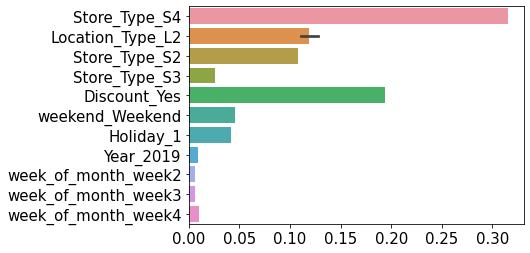

In [147]:
sns.barplot(rf1_model.feature_importances_,x1train.columns)

### building Gradient Boost Regressor

In [148]:
from sklearn.ensemble import GradientBoostingRegressor

In [149]:
gbr = GradientBoostingRegressor(n_estimators = 500,learning_rate=0.01, max_depth = 3, random_state = 10)

In [150]:
gb_model= gbr.fit(xtrain, ytrain)

In [151]:
ypred_test= gb_model.predict(xtest)

In [152]:
ypred_train= gb_model.predict(xtrain)

In [153]:
test_rmse = np.sqrt(mean_squared_error(ytest, ypred_test))
train_rmse = np.sqrt(mean_squared_error(ytrain, ypred_train)) 
print('RMSE train:',train_rmse)
print('RMSE test:',test_rmse)

RMSE train: 9529.712129377987
RMSE test: 9562.206089415384


In [154]:
print('MAPE on  rf_training data set: ', mape(ytrain,ypred_train))
print('MAPE on  rf_test data set: ', mape(ytest,ypred_test))

MAPE on  rf_training data set:  19.29032040338815
MAPE on  rf_test data set:  19.536481088230882


In [155]:
print(' Score_train:',gb_model.score(xtrain,ytrain))
print(' Score_test:',gb_model.score(xtest,ytest))

 Score_train: 0.6348190468457602
 Score_test: 0.6322672947548469


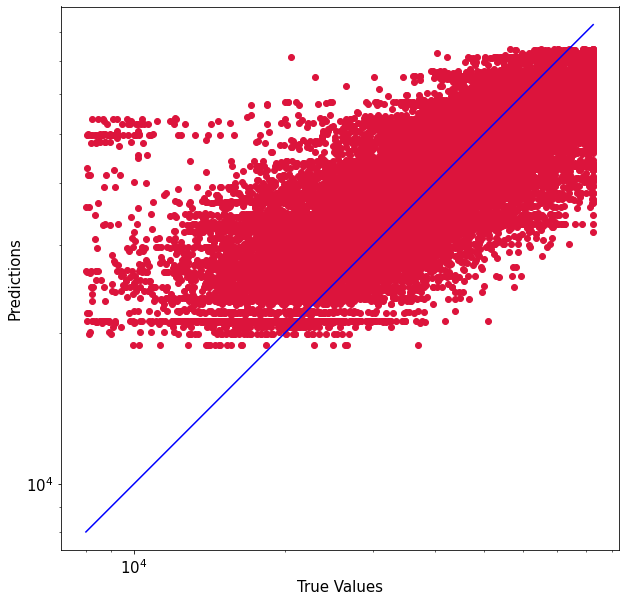

In [156]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(ytest, ypred_test, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(ypred_test), max(ytest))
p2 = min(min(ypred_test), min(ytest))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [157]:
gbr = GradientBoostingRegressor(n_estimators = 200,learning_rate=0.01, max_depth = 3, random_state = 10)

RMSE train: 10422.907931384221
RMSE test: 10450.3208027538
Score_train: 0.563156017916453
Score_test: 0.5607868820925954


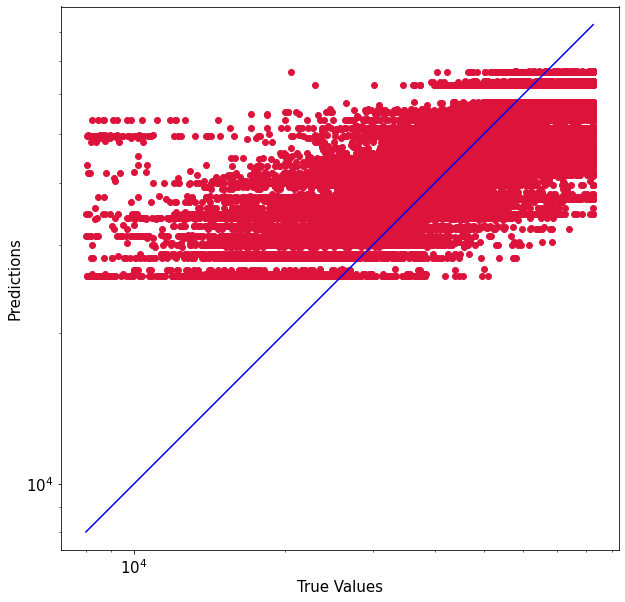

In [158]:
gb_model= gbr.fit(xtrain, ytrain)

ypred_test= gb_model.predict(xtest)

ypred_train= gb_model.predict(xtrain)


test_rmse = np.sqrt(mean_squared_error(ytest, ypred_test))
train_rmse = np.sqrt(mean_squared_error(ytrain, ypred_train)) 
print('RMSE train:',train_rmse)
print('RMSE test:',test_rmse)
print('Score_train:',gb_model.score(xtrain, ytrain))
print('Score_test:',gb_model.score(xtest, ytest))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(ytest, ypred_test, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(ypred_test), max(ytest))
p2 = min(min(ypred_test), min(ytest))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [159]:
gb_model.feature_importances_

array([0.00000000e+00, 8.40550201e-02, 4.26849172e-02, 3.10441644e-01,
       2.63955981e-01, 3.11480910e-03, 6.56425934e-03, 2.03254841e-02,
       0.00000000e+00, 4.19593825e-04, 0.00000000e+00, 2.84291295e-02,
       2.02201322e-01, 2.53672754e-04, 6.54389901e-05, 0.00000000e+00,
       0.00000000e+00, 4.31705181e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.31716756e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [160]:
gbr = GradientBoostingRegressor(n_estimators = 200,learning_rate=0.1, max_depth = 3, random_state = 10)


RMSE train: 9022.859096409926
RMSE test: 9056.8501947048
Score_train: 0.6726314875912471
Score_test: 0.6701090313287028


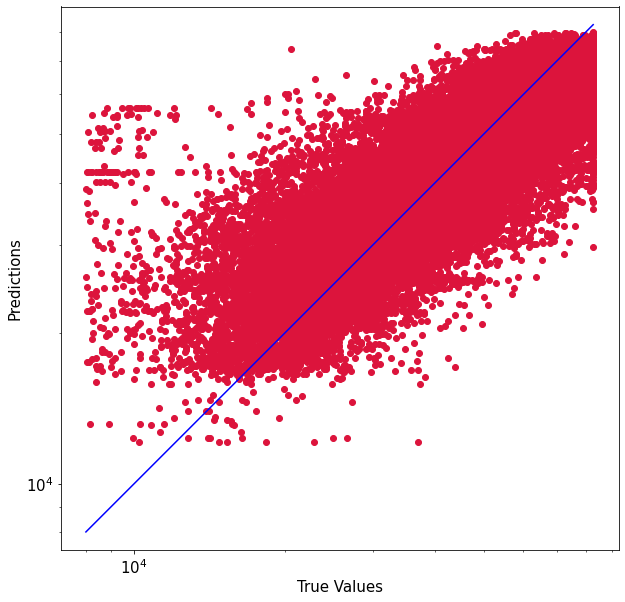

In [162]:
gb_model= gbr.fit(xtrain, ytrain)

ypred_test= gb_model.predict(xtest)

ypred_train= gb_model.predict(xtrain)

test_rmse = np.sqrt(mean_squared_error(ytest, ypred_test))
train_rmse = np.sqrt(mean_squared_error(ytrain, ypred_train)) 
print('RMSE train:',train_rmse)
print('RMSE test:',test_rmse)

print('Score_train:',gb_model.score(xtrain, ytrain))
print('Score_test:',gb_model.score(xtest, ytest))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(ytest, ypred_test, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(ypred_test), max(ytest))
p2 = min(min(ypred_test), min(ytest))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [163]:
gbr = GradientBoostingRegressor(n_estimators = 200,learning_rate=0.1, max_depth = 2, random_state = 10)


RMSE train: 9325.618180780824
RMSE test: 9342.460612717981
score: 0.6489745468858796


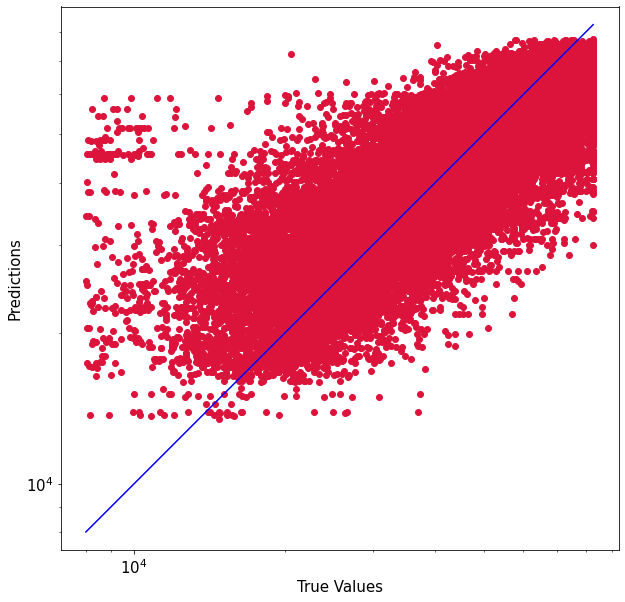

In [164]:
gb_model= gbr.fit(xtrain, ytrain)

ypred_test= gb_model.predict(xtest)

ypred_train= gb_model.predict(xtrain)


test_rmse = np.sqrt(mean_squared_error(ytest, ypred_test))
train_rmse = np.sqrt(mean_squared_error(ytrain, ypred_train)) 
print('RMSE train:',train_rmse)
print('RMSE test:',test_rmse)
print('score:',gb_model.score(xtest, ytest))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(ytest, ypred_test, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(ypred_test), max(ytest))
p2 = min(min(ypred_test), min(ytest))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### Randomized SearchCV

In [165]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [166]:
gbr = GradientBoostingRegressor()
parameters = {'learning_rate': sp_randFloat(),
              'subsample'    : sp_randFloat(),
              'n_estimators' : sp_randInt(100, 1000),
              'max_depth'    : sp_randInt(4, 10)
              }

In [167]:
randm_src=RandomizedSearchCV(estimator=gbr,param_distributions=parameters,cv=3,n_iter=10,n_jobs=-1)
randm_src.fit(xtrain,ytrain)

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BFE13FDE50>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BFE1263D00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BFE1284700>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BFE127FBE0>})

In [168]:
randm_src.best_params_

{'learning_rate': 0.6844514590172226,
 'max_depth': 4,
 'n_estimators': 842,
 'subsample': 0.977793219529047}

In [169]:
randm_src.best_score_

0.7219603062720443

In [170]:
randm_src.best_estimator_

GradientBoostingRegressor(learning_rate=0.6844514590172226, max_depth=4,
                          n_estimators=842, subsample=0.977793219529047)

In [212]:
gbr_rand=GradientBoostingRegressor(n_estimators=842,learning_rate=0.6844514590172226,max_depth=4, subsample=0.9262177535080487,
                                   random_state=10)
gbr_rand_model=gbr_rand.fit(xtrain,ytrain)

In [213]:
ypred_gbr_train=gbr_rand_model.predict(xtrain)
ypred_gbr_test=gbr_rand_model.predict(xtest)
test_rmse = np.sqrt(mean_squared_error(ytest, ypred_gbr_test))
train_rmse = np.sqrt(mean_squared_error(ytrain, ypred_gbr_train)) 
print('RMSE train:',train_rmse)
print('RMSE test:',test_rmse)
print('Score_train:',gbr_rand_model.score(xtrain, ytrain))
print('Score_test:',gbr_rand_model.score(xtest, ytest))
print('MAPE_train : ', mape(ytrain,ypred_gbr_train))
print('MAPE_test : ', mape(ytest,ypred_gbr_test))

RMSE train: 8099.510626722122
RMSE test: 8311.171826744323
Score_train: 0.7362052710784595
Score_test: 0.72219466630731
MAPE_train :  15.892397821466297
MAPE_test :  16.402444612659252


In [214]:
gbr_rand=GradientBoostingRegressor(n_estimators=387,learning_rate=0.5101468707452217,max_depth=4, subsample=0.9262177535080487,
                                   random_state=10)
gbr_rand_model=gbr_rand.fit(xtrain,ytrain)

In [215]:
ypred_gbr_train=gbr_rand_model.predict(xtrain)
ypred_gbr_test=gbr_rand_model.predict(xtest)
test_rmse = np.sqrt(mean_squared_error(ytest, ypred_gbr_test))
train_rmse = np.sqrt(mean_squared_error(ytrain, ypred_gbr_train)) 
print('RMSE train:',train_rmse)
print('RMSE test:',test_rmse)
print('Score_train:',gbr_rand_model.score(xtrain, ytrain))
print('Score_test:',gbr_rand_model.score(xtest, ytest))
print('MAPE_train : ', mape(ytrain,ypred_gbr_train))
print('MAPE_test : ', mape(ytest,ypred_gbr_test))

RMSE train: 8195.093922313541
RMSE test: 8335.553892646218
Score_train: 0.7299423869074766
Score_test: 0.7205623084193549
MAPE_train :  16.1122102534163
MAPE_test :  16.502778936468648


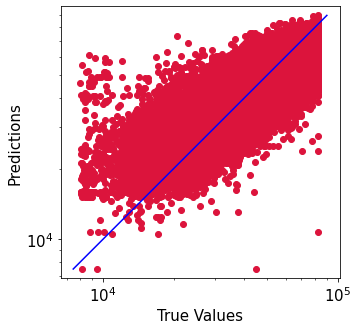

In [173]:
plt.figure(figsize=(5,5))
plt.scatter(ytest, ypred_gbr_test, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(ypred_gbr_test), max(ytest))
p2 = min(min(ypred_gbr_test), min(ytest))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### GridSearchCv Gradient Boosting

In [174]:
GBR=GradientBoostingRegressor()
search_grid={'n_estimators':[100,200,500],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4]}
search_gbr=GridSearchCV(estimator=GBR,param_grid=search_grid,n_jobs=1,cv=3)

In [175]:
search_gbr.fit(xtrain,ytrain)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [1, 2, 4],
                         'n_estimators': [100, 200, 500]})

In [176]:
search_gbr.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}

In [177]:
search_gbr.best_estimator_

GradientBoostingRegressor(max_depth=4, n_estimators=500)

In [178]:
best_gbr=GradientBoostingRegressor(n_estimators=500,learning_rate=0.1,max_depth=4)
best_gbrmodel=best_gbr.fit(xtrain,ytrain)

In [179]:
ypred_gbrbest_train=best_gbrmodel.predict(xtrain)
ypred_gbrbest_test=best_gbrmodel.predict(xtest)
test_rmse = np.sqrt(mean_squared_error(ytest, ypred_gbrbest_test))
train_rmse = np.sqrt(mean_squared_error(ytrain, ypred_gbrbest_train)) 
print('RMSE train:',train_rmse)
print('RMSE test:',test_rmse)
print('Score_train:',best_gbrmodel.score(xtrain, ytrain))
print('Score_test:',best_gbrmodel.score(xtest, ytest))
print('MAPE_train : ', mape(ytrain,ypred_gbrbest_train))
print('MAPE_test : ', mape(ytest,ypred_gbrbest_test))

RMSE train: 8517.547107055529
RMSE test: 8574.635591081402
Score_train: 0.7082723171198324
Score_test: 0.704302670735413
MAPE_train :  16.789147439596956
MAPE_test :  17.069162284019164


### XGBoost Regressor

In [180]:
import xgboost as xg

In [181]:
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, random_state=10)

In [182]:
xgb_r.fit(xtrain, ytrain)
  
# Predict the model
test_pred = xgb_r.predict(xtest)
train_pred= xgb_r.predict(xtrain)
# RMSE Computation
rmse_test = np.sqrt(mean_squared_error(ytest, test_pred))
rmse_train = np.sqrt(mean_squared_error(ytrain, train_pred))
print("rmse test:",rmse_test)
print("rmse train:",rmse_train)

[02:51:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
rmse test: 9291.944610041719
rmse train: 9249.928631102472


[02:51:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
score: 0.6527603721968581


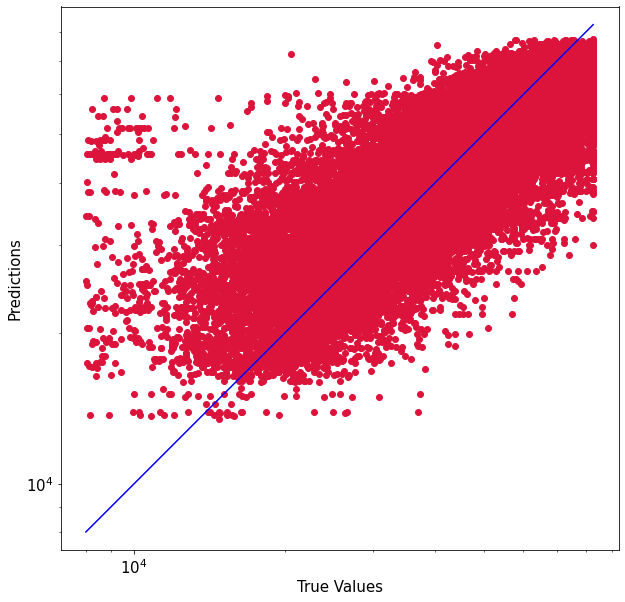

In [183]:
print('score:',xgb_r.fit(xtrain, ytrain).score(xtest, ytest))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(ytest, ypred_test, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(ypred_test), max(ytest))
p2 = min(min(ypred_test), min(ytest))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### XGBoost with Randomized search parameters

In [184]:
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators=387,learning_rate=0.5101468707452217,max_depth=4, subsample=0.9262177535080487,
                                   random_state=10)

[02:51:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
RMSE train: 8196.518941502212
RMSE test: 8333.171184058283
Score_train: 0.7298484597985437
Score_test: 0.7207220394784669
MAPE_train :  16.12114453868903
MAPE_test :  16.50294621139047


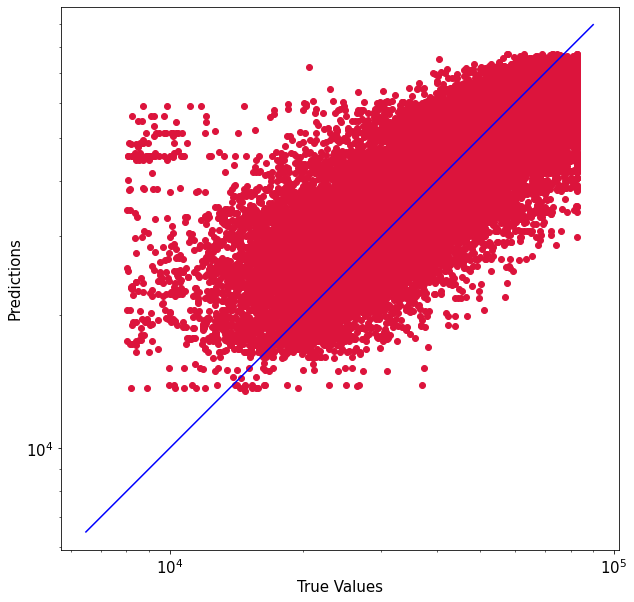

In [185]:
xg=xgb_r.fit(xtrain, ytrain)
  
# Predict the model
test_pred = xgb_r.predict(xtest)
train_pred= xgb_r.predict(xtrain)
# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(ytest, test_pred))
train_rmse = np.sqrt(mean_squared_error(ytrain, train_pred))
print('RMSE train:',train_rmse)
print('RMSE test:',test_rmse)
print('Score_train:',xg.score(xtrain, ytrain))
print('Score_test:',xg.score(xtest, ytest))
print('MAPE_train : ', mape(ytrain,train_pred))
print('MAPE_test : ', mape(ytest,test_pred))

plt.figure(figsize=(10,10))
plt.scatter(ytest, ypred_test, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(test_pred), max(ytest))
p2 = min(min(test_pred), min(ytest))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [186]:
# test data

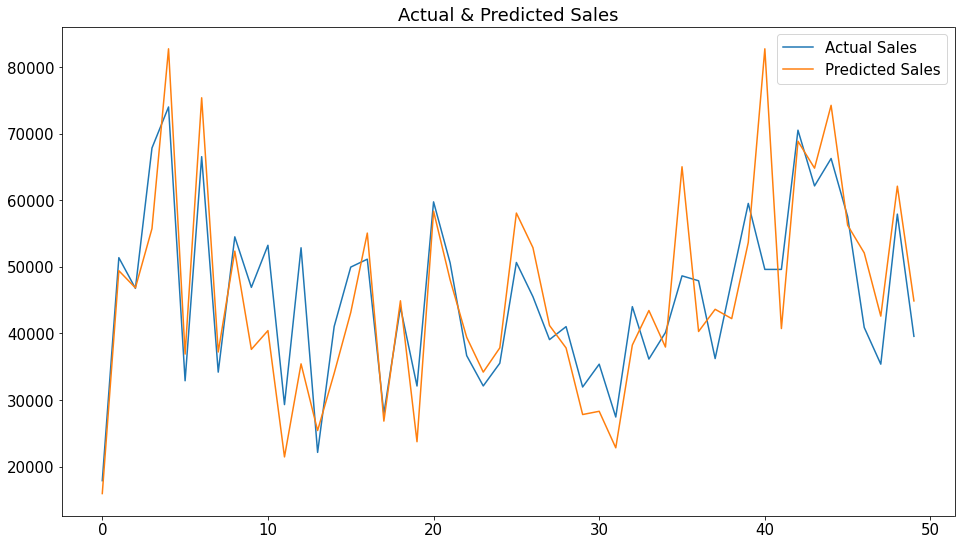

In [187]:
train = pd.DataFrame(
    {'Predicted Sales':test_pred, 'Actual Sales':ytest}
)

fig= plt.figure(
    figsize=(16, 9)
)

train = train.reset_index()
train = train.drop(
    ['index'],axis=1
)

plt.plot(train[:50])
plt.legend(['Actual Sales','Predicted Sales'])
plt.title('Actual & Predicted Sales')
plt.show()

# Randomised search XGB

In [188]:
from xgboost import XGBRegressor

In [189]:
XGB=XGBRegressor()
parameters = {'learning_rate': sp_randFloat(),
              'subsample'    : sp_randFloat(),
              'n_estimators' : sp_randInt(100, 1000),
              'max_depth'    : sp_randInt(4, 10)
              }

In [190]:
randm_src=RandomizedSearchCV(estimator=XGB,param_distributions=parameters,cv=3,n_iter=10,n_jobs=-1)
randm_src.fit(xtrain,ytrain)


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BFE124FDF0>,
                                        'max_depth': <scip

In [191]:

randm_src.best_params_


{'learning_rate': 0.2449603630038799,
 'max_depth': 7,
 'n_estimators': 607,
 'subsample': 0.6293898460531937}

In [192]:

randm_src.best_score_


0.709650230318894

In [193]:

randm_src.best_estimator_


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2449603630038799,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=607, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.6293898460531937,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [216]:
gbr_rand=GradientBoostingRegressor(n_estimators=607,learning_rate= 0.2449603630038799,max_depth=7, subsample=0.6293898460531937,
                                   random_state=10)
gbr_rand_model=gbr_rand.fit(xtrain,ytrain)

In [217]:
ypred_gbr_train=gbr_rand_model.predict(xtrain)
ypred_gbr_test=gbr_rand_model.predict(xtest)
test_rmse = np.sqrt(mean_squared_error(ytest, ypred_gbr_test))
train_rmse = np.sqrt(mean_squared_error(ytrain, ypred_gbr_train)) 
print('RMSE train:',train_rmse)
print('RMSE test:',test_rmse)
print('Score_train:',gbr_rand_model.score(xtrain, ytrain))
print('Score_test:',gbr_rand_model.score(xtest, ytest))
print('MAPE_train : ', mape(ytrain,ypred_gbr_train))
print('MAPE_test : ', mape(ytest,ypred_gbr_test))

RMSE train: 7845.209688997561
RMSE test: 8434.58548943782
Score_train: 0.752509993950568
Score_test: 0.7138830766865
MAPE_train :  15.28705435983468
MAPE_test :  16.595971041445384


In [194]:
gbr_rand=GradientBoostingRegressor(n_estimators=897,learning_rate=0.5990485766454854,max_depth=4, subsample=0.49305511030545746,
                                   random_state=10)
gbr_rand_model=gbr_rand.fit(xtrain,ytrain)



In [195]:
ypred_gbr_train=gbr_rand_model.predict(xtrain)
ypred_gbr_test=gbr_rand_model.predict(xtest)
test_rmse = np.sqrt(mean_squared_error(ytest, ypred_gbr_test))
train_rmse = np.sqrt(mean_squared_error(ytrain, ypred_gbr_train)) 
print('RMSE train:',train_rmse)
print('RMSE test:',test_rmse)
print('Score_train:',gbr_rand_model.score(xtrain, ytrain))
print('Score_test:',gbr_rand_model.score(xtest, ytest))
print('MAPE_train : ', mape(ytrain,ypred_gbr_train))
print('MAPE_test : ', mape(ytest,ypred_gbr_test))

RMSE train: 8154.455757137056
RMSE test: 8357.280032998735
Score_train: 0.7326140915228284
Score_test: 0.7191037336024725
MAPE_train :  16.039073750762405
MAPE_test :  16.531096628464432


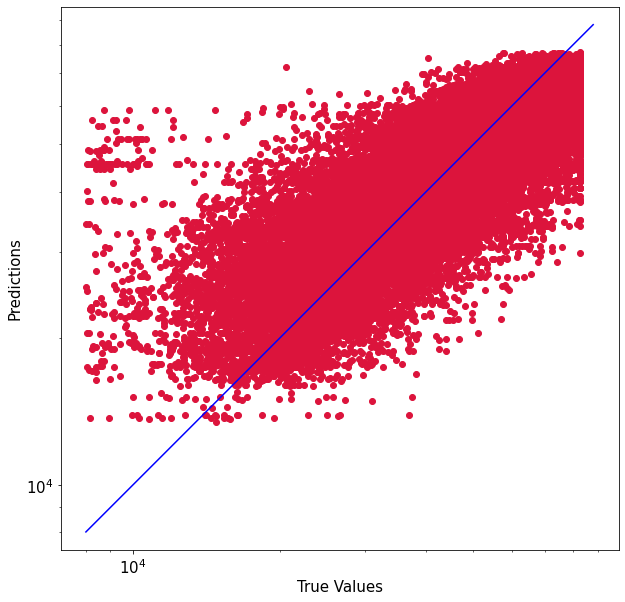

In [196]:

plt.figure(figsize=(10,10))
plt.scatter(ytest, ypred_test, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(ypred_gbrbest_test), max(ytest))
p2 = min(min(ypred_gbrbest_test), min(ytest))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [197]:
features = df_base.drop(['Sales','Order'],axis=1)

target = df_base['Sales']


xtrain,xtest,ytrain,ytest = train_test_split(features,target,test_size=.30,random_state=10)

In [198]:
features.shape

(183851, 29)

In [199]:
XGB=XGBRegressor()
search_grid={'n_estimators':range(350,450,20),'learning_rate':[0.45,0.5,0.4],'max_depth':[3,4,5]}
search_gbr=GridSearchCV(estimator=XGB,param_grid=search_grid,n_jobs=1,cv=3)

In [200]:
search_gbr.fit(xtrain,ytrain)


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
       

In [201]:

search_gbr.best_params_


{'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 350}

In [202]:

search_gbr.best_estimator_


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.4, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=350, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [203]:

best_gbr=XGBRegressor(n_estimators=350,learning_rate=0.4,max_depth=5)
best_gbrmodel=best_gbr.fit(xtrain,ytrain)


In [204]:

ypred_gbrbest_train=best_gbrmodel.predict(xtrain)
ypred_gbrbest_test=best_gbrmodel.predict(xtest)
test_rmse = np.sqrt(mean_squared_error(ytest, ypred_gbrbest_test))
train_rmse = np.sqrt(mean_squared_error(ytrain, ypred_gbrbest_train)) 
print('RMSE train:',train_rmse)
print('RMSE test:',test_rmse)
print('Score_train:',best_gbrmodel.score(xtrain, ytrain))
print('Score_test:',best_gbrmodel.score(xtest, ytest))
print('MAPE_train : ', mape(ytrain,ypred_gbrbest_train))
print('MAPE_test : ', mape(ytest,ypred_gbrbest_test))



RMSE train: 8076.350440745982
RMSE test: 8291.441812276296
Score_train: 0.737711732466661
Score_test: 0.7235120731738485
MAPE_train :  15.816636673800112
MAPE_test :  16.359786518051695


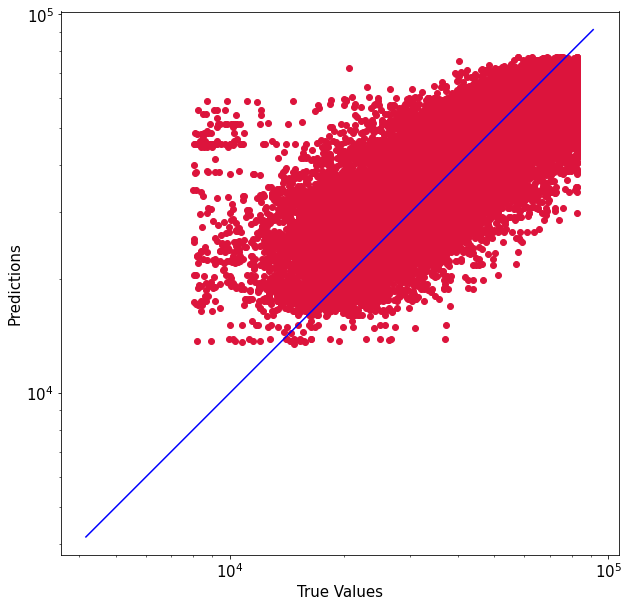

In [205]:

plt.figure(figsize=(10,10))
plt.scatter(ytest, ypred_test, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(ypred_gbrbest_test), max(ytest))
p2 = min(min(ypred_gbrbest_test), min(ytest))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [206]:

best_gbr=XGBRegressor(n_estimators=380,learning_rate=0.59,max_depth=5)
best_gbrmodel=best_gbr.fit(xtrain,ytrain)



In [207]:


ypred_gbrbest_train=best_gbrmodel.predict(xtrain)
ypred_gbrbest_test=best_gbrmodel.predict(xtest)
test_rmse = np.sqrt(mean_squared_error(ytest, ypred_gbrbest_test))
train_rmse = np.sqrt(mean_squared_error(ytrain, ypred_gbrbest_train)) 
print('RMSE train:',train_rmse)
print('RMSE test:',test_rmse)
print('Score_train:',best_gbrmodel.score(xtrain, ytrain))
print('Score_test:',best_gbrmodel.score(xtest, ytest))
print('MAPE_train : ', mape(ytrain,ypred_gbrbest_train))
print('MAPE_test : ', mape(ytest,ypred_gbrbest_test))



RMSE train: 8022.387968280241
RMSE test: 8293.998231919688
Score_train: 0.7412050031392403
Score_test: 0.7233415532216747
MAPE_train :  15.700812437595916
MAPE_test :  16.372630176021204


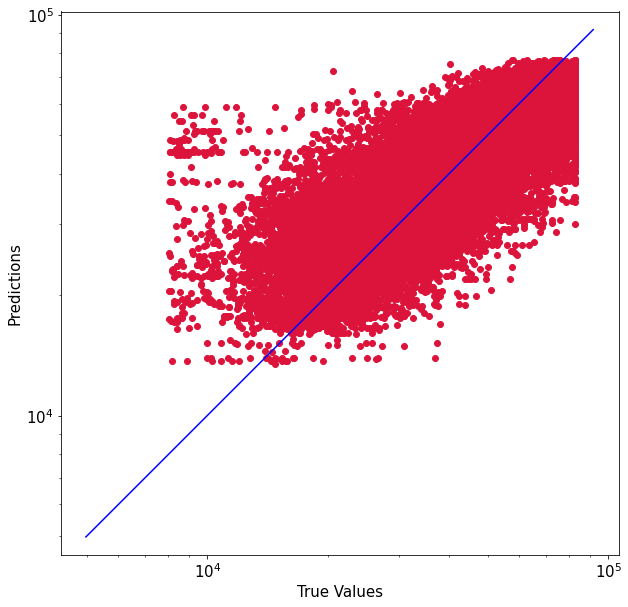

In [208]:
plt.figure(figsize=(10,10))
plt.scatter(ytest, ypred_test, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(ypred_gbrbest_test), max(ytest))
p2 = min(min(ypred_gbrbest_test), min(ytest))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

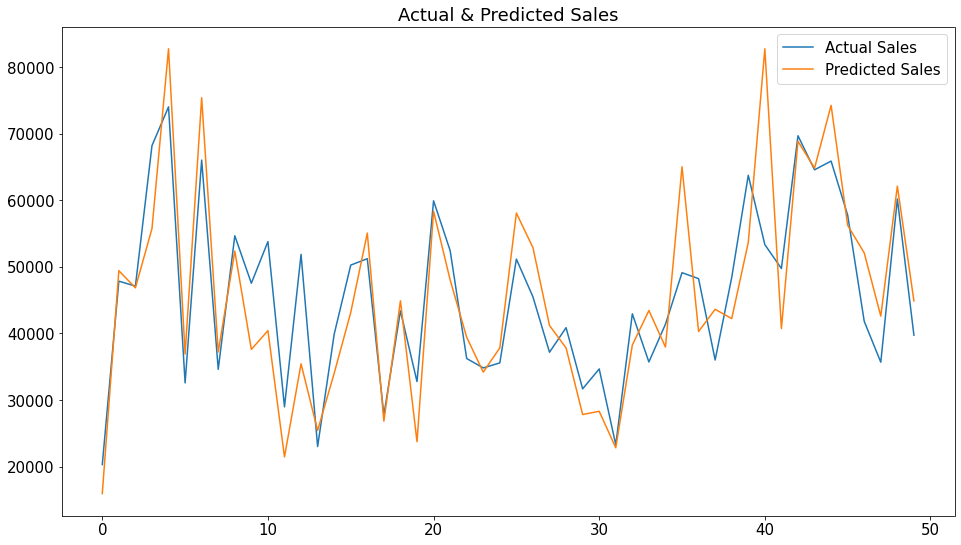

In [209]:
train = pd.DataFrame(
    {'Predicted Sales':ypred_gbrbest_test, 'Actual Sales':ytest}
)

fig= plt.figure(
    figsize=(16, 9)
)

train = train.reset_index()
train = train.drop(
    ['index'],axis=1
)

plt.plot(train[:50])
plt.legend(['Actual Sales','Predicted Sales'])
plt.title('Actual & Predicted Sales')
plt.show()

## XGBOOST REGRESSOR with n_estimators=380,learning_rate=0.59,max_depth=5
## has given the best results

## RMSE train: 8022.387968280241
## RMSE test: 8293.998231919688
## Score_train: 0.7412050031392403
## Score_test: 0.7233415532216747
## MAPE_train :  15.700812437595916
## MAPE_test :  16.372630176021204